# Analysis for power of *p*-values in published RNA-Seq data sets
This file analyzes all published RNA-seq data published between 1.Jan.2017 and 1.Jun.2018.
URL:	https://www.ncbi.nlm.nih.gov/gds
	
Mouse:	
Search:	csv[All Fields] AND sequencing[All Fields] AND "Mus musculus"[porgn] AND ("2017/01/01"[PDAT] : "2018/06/30"[PDAT]) 

Search Date: 	30-Aug-18
	
Human:	
Search:	csv[All Fields] AND sequencing[All Fields] AND "Homo sapiens"[porgn] AND ("2017/01/01"[PDAT] : "2018/06/30"[PDAT]) 

Search Date: 	4-Sep-18
	
Inclusion criteria:	
1. Count matrix in CSV format provided	
2. Paper published.	
3. Each group with at least 3 replicates.

First, we import analysis tools.

In [1]:
import sys, imp, time, pandas as pd, re
%pylab inline
import scipy.stats as ss
if 'rudolphLab/scripts' not in sys.path: sys.path.insert(0, '/Users/jiangnan/Documents/rudolphLab/scripts')
import GEOparse
import pandas as pd
import rosely
imp.reload(rosely)
from rosely import *
from collections import OrderedDict
results = {'Mouse':{}, 'Human':{}}

Populating the interactive namespace from numpy and matplotlib
Rosely version: 1.3.0
import time: 2019-05-15 17:23:58.353769+02:00
Rosely version: 1.3.0
import time: 2019-05-15 17:23:58.359633+02:00


In [2]:
def load_data(fn, normcutoff, **kwargs):
    cr = CountReads('~/Downloads/' + fn, **kwargs)
    cr.normalize_data(normalize_by='quantile5', normcutoff=normcutoff)
    print('Library size:', len(cr.seqids))
    groups = list(cr.data.keys())
    print('groups:', groups)
    for n in cr.nRefs: print(n, ':', cr.nRefs[n])
    return cr

def analyze(sp, cr, ga, group1, group2, ref, grp='', **kwargs2):
    pops = {}; sig = {}
    for (do_SVA, ridge, name, method) in [(False, False, 'Ordinary', ''), 
                                          (True, False, 'SVA', ''), 
                                          (True, True, 'SVA ridge', ''),
                                          (False, False, 'Ascertained', 'ascertained_ttest'),
#                                           (True, True, 'Asc. SVA ridge', 'ascertained_ttest')
                                 ]:
        datalist = [cr.normdata[group1], cr.normdata[group2]]
        res = count_analysis(datalist, 
                             method=method, do_SVA=do_SVA, ridge = ridge, nSV=2, 
                             debug=True, with_plot=False, weighted=False, 
                             minn=2, data_name=name, parallel=False, **kwargs2)
        pops[name + ' power of p values'] = res.pop
        sig [name + ' LFDR < 0.3'] = sum(res.LFDR < 0.3)
        if do_SVA: pops[name + ' GLM power of p values'] = res.vbs['SVApop']
    n1 = cr.normdata[group1].shape[1]
    n2 = cr.normdata[group2].shape[1]
    compare = grp + group1 + '(' + str(n1) + ') ~ ' + group2 +'(' + str(n2) + ')'
    print('result shape:', res.results.shape)
    results[sp][(ga, compare)] = OrderedDict({**pops, **sig,
                              'Mean of n number': (n1 + n2) / 2,
                              '# of analyzed genes':res.results.shape[0],
                              'Citation': ref
                  })
    print(pops)
    return res

## Mouse GEO analysis

In [3]:
ga = 'GSE97976'
cr = load_data('GSE97976_featureCounts.mm10.e81.csv', 10, sep='\t', igroup=1)
ref = 'Schmidt K, Zhang Q, Tasdogan A, Petzold A et al. The H3K4 methyltransferase Setd1b is essential for hematopoietic stem and progenitor cell homeostasis in mice. Elife 2018 Jun 19;7. PMID: 29916805'
res = analyze('Mouse', cr, ga, 'HOM', 'HET', ref, transform='log5', minmean=10)

Library size: 45706
groups: [('HET', 'AI03'), ('HET', 'AI54'), ('HET', 'AI56'), ('HOM', 'AH74'), ('HOM', 'AI02'), ('HOM', 'AI55')]
('HET', 'AI03') : 259.24440789473687
('HET', 'AI54') : 423.3825657894737
('HET', 'AI56') : 312.33947368421053
('HOM', 'AH74') : 289.13947368421054
('HOM', 'AI02') : 299.99440789473687
('HOM', 'AI55') : 314.1016447368421
SVA pop of design variable: 0.568975707874
SVA pop of design variable for ridge regression: 0.720532598356
0.61; result shape: (14745, 4)
{'Ordinary power of p values': 0.61614561995581363, 'SVA power of p values': 0.49474789211672182, 'SVA GLM power of p values': 0.56897570787376062, 'SVA ridge power of p values': 0.58265755125183427, 'SVA ridge GLM power of p values': 0.7205325983562505, 'Ascertained power of p values': 0.582789123156219}


In [4]:
# ga = 'GSE105046' # This is Nanostring, not RNA-seq
# cr = load_data('GSE105046_NS_Mecp2_raw.csv' , 10, sep=',', igroup=1, group_sample_sep='_')
# ref = 'Raman AT, Pohodich AE, Wan YW, Yalamanchili HK et al. Apparent bias toward long gene misregulation in MeCP2 syndromes disappears after controlling for baseline variations. Nat Commun 2018 Aug 13;9(1):3225. PMID: 30104565'
# res = analyze('Mouse', cr, ga, 'KO', 'WT', ref, transform='log5', minmean=10)

In [5]:
ga = 'GSE104530'
cr = load_data('GSE104530_seq_processed_counts_results.csv', 10, sep=',', igroup=1, group_sample_sep='.')
ref = 'Nelson JW, Ferdaus MZ, McCormick JA, Minnier J et al. Endothelial transcriptomics reveals activation of fibrosis-related pathways in hypertension. Physiol Genomics 2018 Feb 1;50(2):104-116. PMID: 29212850'
res = analyze('Mouse', cr, ga, 'youngBPH2J', 'oldBPH2J', ref, transform='log5', minmean=10)
res = analyze('Mouse', cr, ga, 'youngBPH2J', 'oldBPN3J', ref, transform='log5', minmean=10)
res = analyze('Mouse', cr, ga, 'oldBPH2J',   'oldBPN3J', ref, transform='log5', minmean=10)

Library size: 18094
groups: [('oldBPH2J', '1'), ('oldBPH2J', '2'), ('oldBPH2J', '3'), ('oldBPN3J', '1'), ('oldBPN3J', '2'), ('oldBPN3J', '3'), ('youngBPH2J', '1'), ('youngBPH2J', '2'), ('youngBPH2J', '3')]
('oldBPH2J', '1') : 616.5953504043126
('oldBPH2J', '2') : 625.0690700808625
('oldBPH2J', '3') : 632.5245956873315
('oldBPN3J', '1') : 584.1337601078167
('oldBPN3J', '2') : 562.6745283018868
('oldBPN3J', '3') : 551.6607142857143
('youngBPH2J', '1') : 638.3429919137467
('youngBPH2J', '2') : 587.0677223719676
('youngBPH2J', '3') : 670.0387466307278
SVA pop of design variable: 0.466863461168
SVA pop of design variable for ridge regression: 0.39457641984
0.313; result shape: (14268, 4)
{'Ordinary power of p values': 0.36354722745794893, 'SVA power of p values': 0.43727303829412889, 'SVA GLM power of p values': 0.46686346116808752, 'SVA ridge power of p values': 0.35443593845662075, 'SVA ridge GLM power of p values': 0.39457641984004643, 'Ascertained power of p values': 0.25203363579341098

In [6]:
# ga = 'GSE85389' # 
# cr1 = load_data('GSE85389_RSEM_counts_NVE.CSV.gz', 10, sep=',', igroup=1, group_sample_sep='_')
# cr2 = load_data('GSE85389_RSEM_counts_SAL.CSV.gz', 10, sep=',', igroup=1, group_sample_sep='_')
# ref = 'Vestal B, Russell P, Radcliffe RA, Bemis L et al. miRNA-regulated transcription associated with mouse strains predisposed to hypnotic effects of ethanol. Brain Behav 2018 Jun;8(6):e00989. PMID: 30106247'
# res = analyze('Mouse', cr1, ga, 'ISS', 'ILS', ref, grp='NVE ', transform='log5', minmean=10)
# res = analyze('Mouse', cr2, ga, 'ISS', 'ILS', ref, grp='SAL ', transform='log5', minmean=10)

In [7]:
ga = 'GSE110243'
cr = load_data('GSE110243_merged_table_full_02_04_2018_submission.csv', 0.1, sep=',', 
                igroup=2, group_sample_sep='_', sample_name_transform=lambda x: x[:-6])
# hist(cr.normdata['WT_L60'].mean(axis=1))
ref = 'Sacta MA, Tharmalingam B, Coppo M, Rollins DA et al. Gene-specific mechanisms direct glucocorticoid-receptor-driven repression of inflammatory response genes in macrophages. Elife 2018 Feb 9;7. PMID: 29424686'
res = analyze('Mouse', cr, ga, 'WT_L60', 'KO_L60', ref, transform=1, minmean=0.1)
res = analyze('Mouse', cr, ga, 'WT_LD60', 'KO_LD60', ref, transform=1, minmean=0.1)

Only the first of the duplicated indices will be kept:
           KO_CO              KO_L60                      KO_LD60           \
         26_log    58_log    .5_log    29_log    61_log   .6_log   30_log   
genes                                                                       
2-Mar  6.074269  6.216108  6.140375  5.938425  6.023938  6.09956  5.99349   

                    WT_CO              WT_L60                       WT_LD60  \
         62_log    34_log    74_log    13_log    37_log    77_log    14_log   
genes                                                                         
2-Mar  5.961969  6.018815  6.903959  5.949492  5.947084  5.883295  5.947709   

                           
         38_log    78_log  
genes                      
2-Mar  5.904391  5.960707  
Library size: 9614
groups: [('KO_CO', '26_log'), ('KO_CO', '58_log'), ('KO_L60', '.5_log'), ('KO_L60', '29_log'), ('KO_L60', '61_log'), ('KO_LD60', '.6_log'), ('KO_LD60', '30_log'), ('KO_LD60', '62_log'), (

In [8]:
ga = 'GSE109177'
cr1 = load_data('GSE109177_Ctrl_Untr_vs_Ctrl_PR20-ExpDiff_k562_.csv', 1, sep=',', 
                igroup=1, group_sample_sep='-')
cr2 = load_data('GSE109177_SafePR50_vs_TMX2PR50-ExpDiff_neurons_.csv', 1, sep=',', 
                igroup=1, group_sample_sep='-')
ref = 'Kramer NJ, Haney MS, Morgens DW, Jovičić A et al. CRISPR-Cas9 screens in human cells and primary neurons identify modifiers of C9ORF72 dipeptide-repeat-protein toxicity. Nat Genet 2018 Apr;50(4):603-612. PMID: 29507424'
res = analyze('Mouse', cr1, ga, 'Ctrl_Untr', 'Ctrl_PR20', ref, transform='log0.5', minmean=1)
res = analyze('Mouse', cr2, ga, 'Safe_PR50', 'TMX2_PR50', ref, transform='log0.5', minmean=1)

Library size: 26475
groups: [('Ctrl_PR20', '1'), ('Ctrl_PR20', '2'), ('Ctrl_PR20', '3'), ('Ctrl_Untr', '1'), ('Ctrl_Untr', '2'), ('Ctrl_Untr', '3')]
('Ctrl_PR20', '1') : 237.46670180408574
('Ctrl_PR20', '2') : 230.24780988612864
('Ctrl_PR20', '3') : 231.5585266409714
('Ctrl_Untr', '1') : 238.1937537143892
('Ctrl_Untr', '2') : 253.9333916209075
('Ctrl_Untr', '3') : 238.42052465624397
Library size: 24411
groups: [('Safe_PR50', '1_S7'), ('Safe_PR50', '2_S8'), ('Safe_PR50', '3_S9'), ('TMX2_PR50', '1_S10'), ('TMX2_PR50', '2_S11'), ('TMX2_PR50', '3_S12')]
('Safe_PR50', '1_S7') : 517.6294938993271
('Safe_PR50', '2_S8') : 517.7389293532964
('Safe_PR50', '3_S9') : 521.8194310077024
('TMX2_PR50', '1_S10') : 521.1947236454022
('TMX2_PR50', '2_S11') : 517.4759170265835
('TMX2_PR50', '3_S12') : 521.1643133039655
SVA pop of design variable: 0.202602452724
SVA pop of design variable for ridge regression: 0.226165425663
0.274; result shape: (13914, 4)
{'Ordinary power of p values': 0.31301770675749618

In [9]:
ga = 'GSE109171'
geo = GEOparse.get_GEO('GSE109171')
ttl = [v.split(': ') for v in geo.phenotype_data['title'].values]
ttl = {v[0]:''.join([i for i in v[1] if not i.isdigit()])+'-'+v[1] for v in ttl}
cr = load_data('GSE109171_TST11134_35_spinalcord_45706genes_noERCC_counts_41.txt', 10, sep='\t', 
                igroup=1, group_sample_sep='-', sample_name_transform=lambda x:ttl[x])
ref = 'Spiller KJ, Restrepo CR, Khan T, Dominique MA et al. Microglia-mediated recovery from ALS-relevant motor neuron degeneration in a mouse model of TDP-43 proteinopathy. Nat Neurosci 2018 Mar;21(3):329-340. '
res = analyze('Mouse', cr, ga, 'Control', 'Recovery', ref, transform='log5', minmean=10)
res = analyze('Mouse', cr, ga, 'EarlyDisease', 'LateDisease', ref, transform='log5', minmean=10)
res = analyze('Mouse', cr, ga, 'Recovery', 'LateDisease', ref, transform='log5', minmean=10)

15-May-2019 17:38:17 INFO GEOparse - File already exist: using local version.
15-May-2019 17:38:17 INFO GEOparse - Parsing ./GSE109171_family.soft.gz: 
15-May-2019 17:38:17 DEBUG GEOparse - DATABASE: GeoMiame
15-May-2019 17:38:17 DEBUG GEOparse - SERIES: GSE109171
15-May-2019 17:38:17 DEBUG GEOparse - PLATFORM: GPL17021
15-May-2019 17:38:17 DEBUG GEOparse - SAMPLE: GSM2934627
15-May-2019 17:38:17 DEBUG GEOparse - SAMPLE: GSM2934628
15-May-2019 17:38:17 DEBUG GEOparse - SAMPLE: GSM2934629
15-May-2019 17:38:17 DEBUG GEOparse - SAMPLE: GSM2934630
15-May-2019 17:38:17 DEBUG GEOparse - SAMPLE: GSM2934631
15-May-2019 17:38:17 DEBUG GEOparse - SAMPLE: GSM2934632
15-May-2019 17:38:17 DEBUG GEOparse - SAMPLE: GSM2934633
15-May-2019 17:38:17 DEBUG GEOparse - SAMPLE: GSM2934634
15-May-2019 17:38:17 DEBUG GEOparse - SAMPLE: GSM2934635
15-May-2019 17:38:17 DEBUG GEOparse - SAMPLE: GSM2934636
15-May-2019 17:38:17 DEBUG GEOparse - SAMPLE: GSM2934637
15-May-2019 17:38:17 DEBUG GEOparse - SAMPLE: GSM29

Library size: 45706
groups: [('Control', 'Control1'), ('Control', 'Control10'), ('Control', 'Control11'), ('Control', 'Control12'), ('Control', 'Control13'), ('Control', 'Control14'), ('Control', 'Control2'), ('Control', 'Control3'), ('Control', 'Control4'), ('Control', 'Control5'), ('Control', 'Control6'), ('Control', 'Control7'), ('Control', 'Control8'), ('Control', 'Control9'), ('EarlyDisease', 'EarlyDisease1'), ('EarlyDisease', 'EarlyDisease3'), ('EarlyDisease', 'EarlyDisease4'), ('EarlyDisease', 'EarlyDisease5'), ('EarlyDisease', 'EarlyDisease6'), ('EarlyDisease', 'EarlyDisease7'), ('EarlyDisease', 'EarlyDisease8'), ('LateDisease', 'LateDisease1'), ('LateDisease', 'LateDisease2'), ('LateDisease', 'LateDisease3'), ('LateDisease', 'LateDisease4'), ('LateDisease', 'LateDisease5'), ('LateDisease', 'LateDisease6'), ('LateDisease', 'LateDisease7'), ('Recovery', 'Recovery2'), ('Recovery', 'Recovery3'), ('Recovery', 'Recovery4'), ('Recovery', 'Recovery5'), ('Recovery', 'Recovery7'), ('Rec

In [10]:
ga = 'GSE75187'
cr = load_data('GSE75187_rpkm.csv.gz', 0.1, sep=',', 
                igroup=1, group_sample_sep='_', sample_name_transform=lambda x:x[4:])
ref = 'Booth CAG, Barkas N, Neo WH, Boukarabila H et al. Ezh2 and Runx1 Mutations Collaborate to Initiate Lympho-Myeloid Leukemia in Early Thymic Progenitors. Cancer Cell 2018 Feb 12;33(2):274-291.e8. PMID: 29438697'
res = analyze('Mouse', cr, ga, 'WT', 'DKOITD', ref, transform='log0.05', minmean=0.1)

Library size: 23420
groups: [('DKOITD', 'S1'), ('DKOITD', 'S2'), ('DKOITD', 'S3'), ('DKOITD', 'S6'), ('ITD', 'S4'), ('ITD', 'S8'), ('WT', 'S5'), ('WT', 'S7'), ('WT', 'S9')]
('DKOITD', 'S1') : 5.4710583845056835
('DKOITD', 'S2') : 5.504187017468019
('DKOITD', 'S3') : 5.785690382029459
('DKOITD', 'S6') : 5.20335850686775
('ITD', 'S4') : 4.864916698053824
('ITD', 'S8') : 4.79319894927986
('WT', 'S5') : 5.193833439420071
('WT', 'S7') : 5.910817080143452
('WT', 'S9') : 5.026872553205231
SVA pop of design variable: 0.525841885592
SVA pop of design variable for ridge regression: 0.511772201857
0.582; result shape: (10632, 4)
{'Ordinary power of p values': 0.62693870492489412, 'SVA power of p values': 0.46019196809339857, 'SVA GLM power of p values': 0.52584188559231404, 'SVA ridge power of p values': 0.40400986085273999, 'SVA ridge GLM power of p values': 0.51177220185723915, 'Ascertained power of p values': 0.56002916888902832}


In [11]:
ga = 'GSE75185'
cr = load_data('GSE75185_rpkm.csv.gz', 0.1, sep=',', 
                igroup=1, group_sample_sep='_', sample_name_transform=lambda x:x[:-1]+'_'+x[-1])
ref = 'Booth CAG, Barkas N, Neo WH, Boukarabila H et al. Ezh2 and Runx1 Mutations Collaborate to Initiate Lympho-Myeloid Leukemia in Early Thymic Progenitors. Cancer Cell 2018 Feb 12;33(2):274-291.e8. PMID: 29438697'
res = analyze('Mouse', cr, ga, 'wt', 'dblKo', ref, transform='log0.05', minmean=0.1)
res = analyze('Mouse', cr, ga, 'wt', 'dblKoFlt3ITD', ref, transform='log0.05', minmean=0.1)
res = analyze('Mouse', cr, ga, 'dblKoFlt3ITD', 'dblKo', ref, transform='log0.05', minmean=0.1)

Library size: 13016
groups: [('dblKo', '1'), ('dblKo', '2'), ('dblKo', '3'), ('dblKo', '4'), ('dblKoFlt3ITD', '1'), ('dblKoFlt3ITD', '2'), ('dblKoFlt3ITD', '3'), ('dblKoFlt3ITD', '4'), ('wt', '1'), ('wt', '2'), ('wt', '3'), ('wt', '4')]
('dblKo', '1') : 7.539011451475475
('dblKo', '2') : 7.46967306842009
('dblKo', '3') : 7.492895148136621
('dblKo', '4') : 7.307110114307127
('dblKoFlt3ITD', '1') : 6.879621008184191
('dblKoFlt3ITD', '2') : 7.66020486361578
('dblKoFlt3ITD', '3') : 7.94139164078058
('dblKoFlt3ITD', '4') : 8.225715023480149
('wt', '1') : 8.788045299859066
('wt', '2') : 7.258938473276557
('wt', '3') : 7.18442871546343
('wt', '4') : 7.526575950030194
SVA pop of design variable: 0.812727709811
SVA pop of design variable for ridge regression: 0.928437472883
0.952; result shape: (11643, 4)
{'Ordinary power of p values': 0.95463459593883704, 'SVA power of p values': 0.80099317316978702, 'SVA GLM power of p values': 0.81272770981082743, 'SVA ridge power of p values': 0.93712095278

In [12]:
ga = 'GSE105768'
cr = load_data('GSE105768_genes_fpkm_table.csv.gz', 0.05, sep=',', 
                igroup=1, group_sample_sep='-')
ref = 'Zhang M, Dong Y, Hu F, Yang D et al. Transcription factor Hoxb5 reprograms B cells into functional T lymphocytes. Nat Immunol 2018 Mar;19(3):279-290. PMID: 29434353'
res = analyze('Mouse', cr, ga, 'Ctr', 'Hoxb5', ref, transform='log0.025', minmean=0.05)

Library size: 37980
groups: [('Ctr', 'rep1'), ('Ctr', 'rep2'), ('Ctr', 'rep3'), ('Ctr', 'rep4'), ('Ctr', 'rep5'), ('Ctr', 'rep6'), ('Ctr', 'rep7'), ('Ctr', 'rep8'), ('Hoxb5', 'rep1'), ('Hoxb5', 'rep2'), ('Hoxb5', 'rep3'), ('Hoxb5', 'rep4'), ('Hoxb5', 'rep5'), ('Hoxb5', 'rep6'), ('Hoxb5', 'rep7'), ('Hoxb5', 'rep8')]
('Ctr', 'rep1') : 4.848150445463568
('Ctr', 'rep2') : 4.8474545300797915
('Ctr', 'rep3') : 4.869291397605882
('Ctr', 'rep4') : 4.999016666052788
('Ctr', 'rep5') : 4.926609944600984
('Ctr', 'rep6') : 4.86458708050952
('Ctr', 'rep7') : 4.624086058635482
('Ctr', 'rep8') : 4.383154637931284
('Hoxb5', 'rep1') : 4.684215103883074
('Hoxb5', 'rep2') : 4.57731355479069
('Hoxb5', 'rep3') : 4.558412382629685
('Hoxb5', 'rep4') : 4.547696966741861
('Hoxb5', 'rep5') : 4.562857646279913
('Hoxb5', 'rep6') : 4.574197091348057
('Hoxb5', 'rep7') : 4.671112505772253
('Hoxb5', 'rep8') : 4.667721205697211
SVA pop of design variable: 0.36588051672
SVA pop of design variable for ridge regression: 0

In [13]:
ga = 'GSE104415'
cr = load_data('GSE104415_counts.csv.gz', 10, sep=',', 
                igroup=2, group_sample_sep='_')
ref = 'Lin S, Nascimento EM, Gajera CR, Chen L et al. Distributed hepatocytes expressing telomerase repopulate the liver in homeostasis and injury. Nature 2018 Apr;556(7700):244-248. PMID: 29618815'
res = analyze('Mouse', cr, ga, 'Tert_pos', 'Tert_neg', ref, transform='log5', minmean=10, paired=True)

Library size: 15565
groups: [('Tert_neg', '1'), ('Tert_neg', '2'), ('Tert_neg', '3'), ('Tert_pos', '1'), ('Tert_pos', '2'), ('Tert_pos', '3')]
('Tert_neg', '1') : 465.2940074906367
('Tert_neg', '2') : 353.71647940074905
('Tert_neg', '3') : 315.174531835206
('Tert_pos', '1') : 433.2003745318352
('Tert_pos', '2') : 477.52322097378277
('Tert_pos', '3') : 447.2685393258427
SVA pop of design variable: 0.413898150833
SVA pop of design variable for ridge regression: 0.487261743968
0.408; result shape: (12777, 4)
{'Ordinary power of p values': 0.46112242644862628, 'SVA power of p values': 0.52723228380817744, 'SVA GLM power of p values': 0.41389815083316733, 'SVA ridge power of p values': 0.49165467176130562, 'SVA ridge GLM power of p values': 0.48726174396778205, 'Ascertained power of p values': 0.3545892999160456}


In [14]:
ga = 'GSE101537'
geo = GEOparse.get_GEO('GSE101537')
ttl = {v.split(': ')[0]:v.split(': ')[1] for v in geo.phenotype_data['title'].values}
ttl['2531'] = ttl['2591'] # 2531 is probably a typo
cr = load_data('GSE101537_countTable.csv.gz', 10, sep='\t', 
                igroup=1, group_sample_sep=' ', sample_name_transform=lambda x:ttl[x]+x)
ref = 'Wong CK, Wade-Vallance AK, Luciani DS, Brindle PK et al. The p300 and CBP Transcriptional Coactivators Are Required for β-Cell and α-Cell Proliferation. Diabetes 2018 Mar;67(3):412-422. PMID: 29217654'
res = analyze('Mouse', cr, ga, 'WT', 'p300', ref, transform='log5', minmean=10)
res = analyze('Mouse', cr, ga, 'WT', 'Triallelic', ref, transform='log5', minmean=10)
res = analyze('Mouse', cr, ga, 'WT', 'CBP', ref, transform='log5', minmean=10)

15-May-2019 17:51:33 INFO GEOparse - File already exist: using local version.
15-May-2019 17:51:33 INFO GEOparse - Parsing ./GSE101537_family.soft.gz: 
15-May-2019 17:51:33 DEBUG GEOparse - DATABASE: GeoMiame
15-May-2019 17:51:33 DEBUG GEOparse - SERIES: GSE101537
15-May-2019 17:51:33 DEBUG GEOparse - PLATFORM: GPL19057
15-May-2019 17:51:33 DEBUG GEOparse - SAMPLE: GSM2705880
15-May-2019 17:51:33 DEBUG GEOparse - SAMPLE: GSM2705881
15-May-2019 17:51:33 DEBUG GEOparse - SAMPLE: GSM2705882
15-May-2019 17:51:33 DEBUG GEOparse - SAMPLE: GSM2705883
15-May-2019 17:51:33 DEBUG GEOparse - SAMPLE: GSM2705884
15-May-2019 17:51:33 DEBUG GEOparse - SAMPLE: GSM2705885
15-May-2019 17:51:33 DEBUG GEOparse - SAMPLE: GSM2705886
15-May-2019 17:51:33 DEBUG GEOparse - SAMPLE: GSM2705887
15-May-2019 17:51:33 DEBUG GEOparse - SAMPLE: GSM2705888
15-May-2019 17:51:33 DEBUG GEOparse - SAMPLE: GSM2705889
15-May-2019 17:51:33 DEBUG GEOparse - SAMPLE: GSM2705890
15-May-2019 17:51:33 DEBUG GEOparse - SAMPLE: GSM27

Library size: 27179
groups: [('CBP', 'KO islet mRNA4902'), ('CBP', 'KO islet mRNA4905'), ('CBP', 'KO islet mRNA5252'), ('Triallelic', 'islet mRNA4652'), ('Triallelic', 'islet mRNA4851'), ('Triallelic', 'islet mRNA4974'), ('WT', 'islet mRNA2365'), ('WT', 'islet mRNA2503'), ('WT', 'islet mRNA2504'), ('WT', 'islet mRNA4903'), ('WT', 'islet mRNA5051'), ('WT', 'islet mRNA5054'), ('p300', 'KO islet mRNA2431'), ('p300', 'KO islet mRNA2505'), ('p300', 'KO islet mRNA2531')]
('CBP', 'KO islet mRNA4902') : 329.321568627451
('CBP', 'KO islet mRNA4905') : 281.97549019607845
('CBP', 'KO islet mRNA5252') : 336.7699346405229
('Triallelic', 'islet mRNA4652') : 1259.3245098039215
('Triallelic', 'islet mRNA4851') : 352.41928104575163
('Triallelic', 'islet mRNA4974') : 351.46993464052287
('WT', 'islet mRNA2365') : 404.9852941176471
('WT', 'islet mRNA2503') : 310.8078431372549
('WT', 'islet mRNA2504') : 376.2091503267974
('WT', 'islet mRNA4903') : 331.2294117647059
('WT', 'islet mRNA5051') : 275.1656862745

In [15]:
ga = 'GSE106692'
cr = load_data('GSE106692_NormalizedCounts.csv.gz', 10, sep=',', 
                igroup=2, group_sample_sep='_')
ref = 'Mathur V, Burai R, Vest RT, Bonanno LN et al. Activation of the STING-Dependent Type I Interferon Response Reduces Microglial Reactivity and Neuroinflammation. Neuron 2017 Dec 20;96(6):1290-1302.e6. PMID: 29268096'
res = analyze('Mouse', cr, ga, 'WT_PBS', 'WT_GCV', ref, transform='log5', minmean=10)
res = analyze('Mouse', cr, ga, 'STINGgt_GCV', 'WT_GCV', ref, transform='log5', minmean=10)
res = analyze('Mouse', cr, ga, 'STINGgt_GCV', 'STINGgt_PBS', ref, transform='log5', minmean=10)
res = analyze('Mouse', cr, ga, 'WT_PBS', 'STINGgt_PBS', ref, transform='log5', minmean=10)

Only the first of the duplicated indices will be kept:
             STINGgt_GCV                                         STINGgt_PBS  \
                    334          340          358           76          336   
Unnamed: 0                                                                    
2-Mar       2162.297032  1915.150425  1309.375074  2063.015946  1854.161597   
1-Mar       2823.026543  2412.344985  3201.719175  3243.614979  3052.980566   

                                           WT_GCV                            \
                    356           42          203          209          215   
Unnamed: 0                                                                    
2-Mar       1929.540083  2118.243908  1170.904377  1864.244384  1859.777275   
1-Mar       3398.723912  3172.077464  3264.041309  3509.714816  2388.996556   

                              WT_PBS                                         
                    220          202          208          211          21

In [16]:
ga = 'GSE102858'
cr = load_data('GSE102858_OP9_DESeq_RPM.csv.gz', 0.1, sep=',', 
                igroup=1, group_sample_sep='-', 
               sample_name_transform=lambda x:x.split('_')[0][:-1] + '-'+x if '_' in x else x,)
ref = 'McGarvey AC, Rybtsov S, Souilhol C, Tamagno S et al. A molecular roadmap of the AGM region reveals BMPER as a novel regulator of HSC maturation. J Exp Med 2017 Dec 4;214(12):3731-3751. PMID: 29093060'
res = analyze('Mouse', cr, ga, 'Rgr', 'Flat', ref, transform='log0.1', minmean=0.2)

Library size: 26888
groups: [('Flat', 'Flat1_RPM'), ('Flat', 'Flat2_RPM'), ('Flat', 'Flat3_RPM'), ('Flat', 'Flat4_RPM'), ('Rgr', 'Rgr1_RPM'), ('Rgr', 'Rgr2_RPM'), ('Rgr', 'Rgr3_RPM'), ('Rgr', 'Rgr4_RPM'), ('Rgr', 'Rgr5_RPM'), ('Rgr', 'Rgr6_RPM')]
('Flat', 'Flat1_RPM') : 18.260241942512668
('Flat', 'Flat2_RPM') : 15.419285882753751
('Flat', 'Flat3_RPM') : 18.399815479528847
('Flat', 'Flat4_RPM') : 17.13194294991024
('Rgr', 'Rgr1_RPM') : 17.163104346606858
('Rgr', 'Rgr2_RPM') : 17.584087005888986
('Rgr', 'Rgr3_RPM') : 16.96818283791368
('Rgr', 'Rgr4_RPM') : 16.659647223780173
('Rgr', 'Rgr5_RPM') : 14.40081104879415
('Rgr', 'Rgr6_RPM') : 14.644728508132323
SVA pop of design variable: 0.423589752122
SVA pop of design variable for ridge regression: 0.357503537709
0.362; result shape: (15808, 4)
{'Ordinary power of p values': 0.42514287058392214, 'SVA power of p values': 0.4528048439173788, 'SVA GLM power of p values': 0.42358975212158961, 'SVA ridge power of p values': 0.40218764127834644, 

In [17]:
ga = 'GSE102857'
cr = load_data('GSE102857_AGM_DESeq_RPM.csv.gz', 0.1, sep=',', 
                igroup=1, group_sample_sep='-', 
               sample_name_transform=lambda x:x.split('_')[0][:-1] + '-'+x if '_' in x else x,)
ref = 'McGarvey AC, Rybtsov S, Souilhol C, Tamagno S et al. A molecular roadmap of the AGM region reveals BMPER as a novel regulator of HSC maturation. J Exp Med 2017 Dec 4;214(12):3731-3751. PMID: 29093060'
res = analyze('Mouse', cr, ga, 'E9D', 'E9V', ref, transform='log0.025', minmean=0.05)
res = analyze('Mouse', cr, ga, 'E10V', 'E9V', ref, transform='log0.025', minmean=0.05)
res = analyze('Mouse', cr, ga, 'E9D', 'E10D', ref, transform='log0.025', minmean=0.05)
res = analyze('Mouse', cr, ga, 'E10V', 'E10D', ref, transform='log0.025', minmean=0.05)

Library size: 28876
groups: [('E10D', 'E10D1_RPM'), ('E10D', 'E10D2_RPM'), ('E10D', 'E10D3_RPM'), ('E10U', 'E10U1_RPM'), ('E10U', 'E10U2_RPM'), ('E10U', 'E10U3_RPM'), ('E10V', 'E10V1_RPM'), ('E10V', 'E10V2_RPM'), ('E10V', 'E10V3_RPM'), ('E9D', 'E9D1_RPM'), ('E9D', 'E9D2_RPM'), ('E9D', 'E9D3_RPM'), ('E9V', 'E9V1_RPM'), ('E9V', 'E9V2_RPM'), ('E9V', 'E9V3_RPM')]
('E10D', 'E10D1_RPM') : 12.946619206114423
('E10D', 'E10D2_RPM') : 12.771051035502914
('E10D', 'E10D3_RPM') : 12.43345285996056
('E10U', 'E10U1_RPM') : 13.275212672583823
('E10U', 'E10U2_RPM') : 13.265735453648869
('E10U', 'E10U3_RPM') : 13.280831097140064
('E10V', 'E10V1_RPM') : 12.968507569033534
('E10V', 'E10V2_RPM') : 13.115525024654813
('E10V', 'E10V3_RPM') : 12.928632790927066
('E9D', 'E9D1_RPM') : 11.900712031558161
('E9D', 'E9D2_RPM') : 11.96180571992109
('E9D', 'E9D3_RPM') : 12.103211489151839
('E9V', 'E9V1_RPM') : 12.978145710059222
('E9V', 'E9V2_RPM') : 12.930268244575931
('E9V', 'E9V3_RPM') : 12.772227564102513
SVA pop

In [18]:
ga = 'GSE97440'
cr = load_data('GSE97440_counts.hs.raw.csv', 10, sep=',', 
                igroup=3, group_sample_sep='-')
ref = ' Cimmino L, Dolgalev I, Wang Y, Yoshimi A et al. Restoration of TET2 Function Blocks Aberrant Self-Renewal and Leukemia Progression. Cell 2017 Sep 7;170(6):1079-1095.e20. PMID: 28823558'
res = analyze('Mouse', cr, ga, 'MOLM13-0-hrs',  'MOLM13-12-hrs', ref, transform='log5', minmean=10)
res = analyze('Mouse', cr, ga, 'MOLM13-12-hrs', 'MOLM13-72-hrs', ref, transform='log5', minmean=10)

Library size: 55736
groups: [('HL60-0-hrs', '1-RNA'), ('HL60-0-hrs', '2-RNA'), ('HL60-0-hrs', '4-RNA'), ('HL60-12-hrs', '12-RNA'), ('HL60-12-hrs', '5-RNA'), ('HL60-12-hrs', '7-RNA'), ('HL60-72-hrs', '13-RNA'), ('HL60-72-hrs', '14-RNA'), ('HL60-72-hrs', '15-RNA'), ('MOLM13-0-hrs', '16-RNA'), ('MOLM13-0-hrs', '18-RNA'), ('MOLM13-0-hrs', '19-RNA'), ('MOLM13-12-hrs', '20-RNA'), ('MOLM13-12-hrs', '21-RNA'), ('MOLM13-12-hrs', '22-RNA'), ('MOLM13-72-hrs', '23-RNA'), ('MOLM13-72-hrs', '25-RNA'), ('MOLM13-72-hrs', '27-RNA')]
('HL60-0-hrs', '1-RNA') : 378.9740601503759
('HL60-0-hrs', '2-RNA') : 706.7048872180451
('HL60-0-hrs', '4-RNA') : 651.1796992481203
('HL60-12-hrs', '12-RNA') : 399.8751879699248
('HL60-12-hrs', '5-RNA') : 413.3481203007519
('HL60-12-hrs', '7-RNA') : 379.3406015037594
('HL60-72-hrs', '13-RNA') : 429.10263157894735
('HL60-72-hrs', '14-RNA') : 435.00977443609025
('HL60-72-hrs', '15-RNA') : 659.9751879699248
('MOLM13-0-hrs', '16-RNA') : 663.6984962406015
('MOLM13-0-hrs', '18-RN

In [19]:
ga = 'GSE81803'
cr = load_data('GSE81803_counttab.txt.gz', 10, sep='\t', 
                igroup=2, group_sample_sep='_', 
               sample_name_transform=lambda x:x.split('_')[-1] + '_'+x if 'e' not in x else x.replace('_', ''))
ref = 'Korb E, Herre M, Zucker-Scharff I, Gresack J et al. Excess Translation of Epigenetic Regulators Contributes to Fragile X Syndrome and Is Alleviated by Brd4 Inhibition. Cell 2017 Sep 7;170(6):1209-1223.e20. PMID: 28823556'
res = analyze('Mouse', cr, ga, 'dmso_ko', 'jq1_ko', ref, transform='log5', minmean=10)
res = analyze('Mouse', cr, ga, 'dmso_ko', 'dmso_wt', ref, transform='log5', minmean=10)
res = analyze('Mouse', cr, ga, 'dmso_wt', 'jq1_wt', ref, transform='log5', minmean=10)
res = analyze('Mouse', cr, ga, 'jq1_ko', 'jq1_wt', ref, transform='log5', minmean=10)

Library size: 37402
groups: [('dmso_ko', 'n1_dmso'), ('dmso_ko', 'n2_dmso'), ('dmso_ko', 'n3_dmso'), ('dmso_wt', 'n1_dmso'), ('dmso_wt', 'n2_dmso'), ('dmso_wt', 'n3_dmso'), ('jq1_ko', 'n1_jq1'), ('jq1_ko', 'n2_jq1'), ('jq1_ko', 'n3_jq1'), ('jq1_wt', 'n1_jq1'), ('jq1_wt', 'n2_jq1'), ('jq1_wt', 'n3_jq1')]
('dmso_ko', 'n1_dmso') : 1153.4126455906821
('dmso_ko', 'n2_dmso') : 1352.0106489184693
('dmso_ko', 'n3_dmso') : 1146.4585690515808
('dmso_wt', 'n1_dmso') : 721.9767054908485
('dmso_wt', 'n2_dmso') : 804.4382695507487
('dmso_wt', 'n3_dmso') : 771.0289517470882
('jq1_ko', 'n1_jq1') : 792.2519134775374
('jq1_ko', 'n2_jq1') : 1568.1850249584027
('jq1_ko', 'n3_jq1') : 695.8079866888519
('jq1_wt', 'n1_jq1') : 1086.2545757071548
('jq1_wt', 'n2_jq1') : 2697.671214642263
('jq1_wt', 'n3_jq1') : 450.33544093178034
SVA pop of design variable: 0.283964741555
SVA pop of design variable for ridge regression: 0.276695081161
0.257; result shape: (14449, 4)
{'Ordinary power of p values': 0.3069374981787

In [20]:
ga = 'GSE91078'
cr = load_data('GSE91078_genes.fpkm.csv', 0.1, sep=',', 
                igroup=1, group_sample_sep='_')
ref = 'Stopp S, Gründl M, Fackler M, Malkmus J et al. Deletion of Gas2l3 in mice leads to specific defects in cardiomyocyte cytokinesis during development. Proc Natl Acad Sci U S A 2017 Jul 25;114(30):8029-8034. PMID: 28698371'
res = analyze('Mouse', cr, ga, 'Gas2l3KO', 'CTR', ref, transform='log0.05', minmean=0.1)

Only the first of the duplicated indices will be kept:
                 CTR                         Gas2l3KO                      
               rep1       rep2       rep3       rep1       rep2       rep3
GeneName                                                                  
2-Mar     14.883736  20.492830  37.142076  19.580543  19.834357  15.866711
1-Mar      0.000000   0.116106   0.033332   0.220304   0.195246   0.183476
Library size: 24421
groups: [('CTR', 'rep1'), ('CTR', 'rep2'), ('CTR', 'rep3'), ('Gas2l3KO', 'rep1'), ('Gas2l3KO', 'rep2'), ('Gas2l3KO', 'rep3')]
('CTR', 'rep1') : 7.406415077921327
('CTR', 'rep2') : 6.558595675328177
('CTR', 'rep3') : 7.127287326167531
('Gas2l3KO', 'rep1') : 7.116639945990786
('Gas2l3KO', 'rep2') : 6.883332166856488
('Gas2l3KO', 'rep3') : 6.852327258759388
SVA pop of design variable: 0.68915025536
SVA pop of design variable for ridge regression: 0.814099402876
1.048; result shape: (14643, 4)
{'Ordinary power of p values': 1.0457958534422973, 'SV

In [21]:
ga = 'GSE99397'
cr = load_data('GSE99397_FPKM_Matrix.csv', 0.05, sep=',', 
                igroup=1, group_sample_sep='_',)
ref = 'van Tuyn J, Jaber-Hijazi F, MacKenzie D, Cole JJ et al. Oncogene-Expressing Senescent Melanocytes Up-Regulate MHC Class II, a Candidate Melanoma Suppressor Function. J Invest Dermatol 2017 Oct;137(10):2197-2207. PMID: 28647344'
res = analyze('Mouse', cr, ga, 'Control', 'CreNeg', ref, transform='log0.025', minmean=0.05)
res = analyze('Mouse', cr, ga, 'Control', 'CrePos', ref, transform='log0.025', minmean=0.05)

Library size: 37819
groups: [('Control', '1'), ('Control', '2'), ('Control', '3'), ('CreNeg', 'MHCPos_1'), ('CreNeg', 'MHCPos_2'), ('CreNeg', 'MHCPos_3'), ('CrePos', 'MHCNeg_1'), ('CrePos', 'MHCNeg_2'), ('CrePos', 'MHCNeg_3')]
('Control', '1') : 3.217807065011654
('Control', '2') : 2.522823739078005
('Control', '3') : 3.1675555778175575
('CreNeg', 'MHCPos_1') : 2.5536041068894137
('CreNeg', 'MHCPos_2') : 2.54371431186315
('CreNeg', 'MHCPos_3') : 4.581481699656393
('CrePos', 'MHCNeg_1') : 2.5899787904028404
('CrePos', 'MHCNeg_2') : 2.325154078097498
('CrePos', 'MHCNeg_3') : 2.6014884379026477
SVA pop of design variable: 0.604881229207
SVA pop of design variable for ridge regression: 0.704379252295
0.642; result shape: (22576, 4)
{'Ordinary power of p values': 0.70229008131763948, 'SVA power of p values': 0.55715663456865328, 'SVA GLM power of p values': 0.60488122920741472, 'SVA ridge power of p values': 0.59412656997135094, 'SVA ridge GLM power of p values': 0.70437925229467224, 'Ascer

In [22]:
ga = 'GSE87602'
cr = load_data('GSE87602_IMD4_vs_IMSL.csv', 0.05, sep=',', 
                igroup=2, group_sample_sep='_',)
ref = 'Pugliese SC, Kumar S, Janssen WJ, Graham BB et al. A Time- and Compartment-Specific Activation of Lung Macrophages in Hypoxic Pulmonary Hypertension. J Immunol 2017 Jun 15;198(12):4802-4812. PMID: 28500078'
res = analyze('Mouse', cr, ga, 'Sea_level', 'Hypoxia_D4', ref, transform='log0.025', minmean=0.05)

Only the first of the duplicated indices will be kept:
                    Hypoxia_D4                        Sea_level             \
                          IM1        IM2        IM3        IMA        IMB   
Gene                                                                        
ENSMUSG00000001027   0.000000   0.000000   0.000000   0.000000   0.000000   
ENSMUSG00000020072   0.088971   0.038909   0.000000   0.000000   0.000000   
ENSMUSG00000021879   0.894643   0.044118   0.288113   0.185548   0.000000   
ENSMUSG00000022105  41.360815  39.451297  36.941372  26.540362  25.859585   
ENSMUSG00000022105   8.725671   5.490144  11.356070  13.053829   7.117304   
ENSMUSG00000022116   0.000000   0.000000   0.000000   0.000000   0.000000   
ENSMUSG00000025515   0.000000   0.000000   0.000000   1.050440   0.000000   
ENSMUSG00000025515   0.000000   0.000000   0.000000   0.000000   0.000000   
ENSMUSG00000025515   0.314680   0.000000   0.000000   2.936897   0.000000   
ENSMUSG00000025515  

In [23]:
ga = 'GSE95682'
cr = load_data('GSE95682_RPKM_-_all_genes.csv', 0.2, sep=',', 
                igroup=1, group_sample_sep='.',
                sample_name_transform=lambda x:x.replace('WE14.quadriceps.', '').replace('predn.', ''))
ref = 'Quattrocelli M, Barefield DY, Warner JL, Vo AH et al. Intermittent glucocorticoid steroid dosing enhances muscle repair without eliciting muscle atrophy. J Clin Invest 2017 Jun 1;127(6):2418-2432. PMID: 28481224'
res = analyze('Mouse', cr, ga, 'daily', 'vehicle', ref, transform='log0.1', minmean=0.2)
res = analyze('Mouse', cr, ga, 'daily', 'weekly', ref, transform='log0.1', minmean=0.2)
res = analyze('Mouse', cr, ga, 'vehicle', 'weekly', ref, transform='log0.1', minmean=0.2)

Only the first of the duplicated indices will be kept:
                  daily                                                vehicle  \
               1.S14.x    2.S15.x     3.S1.x     4.S3.x     5.S8.x     1.S2.x   
gene.y                                                                          
1-Mar         5.098344   5.279258   4.624744   5.451700   8.002474   3.721934   
Mical3       75.200569  67.412064  65.963457  62.065509  68.384779  64.684655   
Taf9          9.205343  10.287785  12.657195   9.854996  10.330467  11.679174   
2-Mar        50.983436  51.438924  46.004035  49.065301  42.194864  58.909239   
Mtcp1         2.832413   2.707312   3.651114   3.145212   2.618992   2.566851   
Nav1          9.205343   7.174376   6.085190   6.500104   8.875471   5.647073   
Supt20        6.231309   7.039011   6.328597   8.596912   6.983977   7.187184   
Metazoa_SRP  28.040890  21.658494  22.880314  38.161901  20.951932  53.262166   

                                                    

In [24]:
ga = 'GSE89272'
cr = load_data('GSE89272_FPKM_Matrix.csv', 0.1, sep=',', 
                igroup=1, group_sample_sep='.',
                sample_name_transform=lambda x: x.split('_', 1)[1]+'.'+x if '_' in x else x)
ref = 'Cole JJ, Robertson NA, Rather MI, Thomson JP et al. Diverse interventions that extend mouse lifespan suppress shared age-associated epigenetic changes at critical gene regulatory regions. Genome Biol 2017 Mar 28;18(1):58. PMID: 28351383'
res = analyze('Mouse', cr, ga, 'df_young', 'df_old', ref, transform='log0.05', minmean=0.1)
res = analyze('Mouse', cr, ga, 'df_young', 'N_young', ref, transform='log0.05', minmean=0.1)
res = analyze('Mouse', cr, ga, 'df_old', 'N_old', ref, transform='log0.05', minmean=0.1)
res = analyze('Mouse', cr, ga, 'N_young', 'N_old', ref, transform='log0.05', minmean=0.1)

Library size: 37809
groups: [('N_old', '5L_N_old'), ('N_old', '6L_N_old'), ('N_old', '7L_N_old'), ('N_old', '8L_N_old'), ('N_young', '13L_N_young'), ('N_young', '14L_N_young'), ('N_young', '15L_N_young'), ('N_young', '16L_N_young'), ('df_old', '1L_df_old'), ('df_old', '2L_df_old'), ('df_old', '3L_df_old'), ('df_old', '4L_df_old'), ('df_young', '10L_df_young'), ('df_young', '34L_df_young'), ('df_young', '35L_df_young'), ('df_young', '9L_df_young')]
('N_old', '5L_N_old') : 3.40017534097294
('N_old', '6L_N_old') : 3.1710372971123757
('N_old', '7L_N_old') : 3.1257811503642015
('N_old', '8L_N_old') : 3.1489482822053234
('N_young', '13L_N_young') : 3.106361609157131
('N_young', '14L_N_young') : 3.7713248051789843
('N_young', '15L_N_young') : 3.113740233819104
('N_young', '16L_N_young') : 3.0532253201094357
('df_old', '1L_df_old') : 2.929118411771407
('df_old', '2L_df_old') : 3.3103022407674327
('df_old', '3L_df_old') : 3.41921650372008
('df_old', '4L_df_old') : 3.6083222167013527
('df_young'

In [25]:
ga1 = 'GSE94264'
cr1 = load_data('GSE94264_ATRWTKO_tumor_nowt1ko1_DE_EdgeR.csv.gz', 10, sep=',', 
                igroup=1, group_sample_sep='-',
                sample_name_transform=lambda x: x[:2]+'-'+x[2:] if '.co' in x else x)
ga2 = 'GSE94263'
cr2 = load_data('GSE94263_c2c3_comparision_DE_EdgeR_Alldata.csv.gz', 10, sep=',', 
                igroup=1, group_sample_sep='_')
ref = 'Chen CF, Ruiz-Vega R, Vasudeva P, Espitia F et al. ATR Mutations Promote the Growth of Melanoma Tumors by Modulating the Immune Microenvironment. Cell Rep 2017 Mar 7;18(10):2331-2342. PMID: 28273450'
res = analyze('Mouse', cr1, ga1+','+ga2, 'wt', 'ko', ref, transform='log5', minmean=10)
res = analyze('Mouse', cr2, ga1+','+ga2, 'c2', 'c3', ref, transform='log5', minmean=10)

Library size: 13382
groups: [('ko', '2.counts'), ('ko', '3.counts'), ('ko', '4.counts'), ('ko', '5.counts'), ('wt', '2.counts'), ('wt', '3.counts'), ('wt', '4.counts'), ('wt', '5.counts')]
('ko', '2.counts') : 1603.7105459985041
('ko', '3.counts') : 1278.4850411368736
('ko', '4.counts') : 1536.004487658938
('ko', '5.counts') : 2040.8848167539268
('wt', '2.counts') : 1619.6275243081525
('wt', '3.counts') : 1560.1267763649962
('wt', '4.counts') : 1983.5426327599102
('wt', '5.counts') : 1637.7752430815258
Library size: 14486
groups: [('c2', 'r1.counts'), ('c2', 'r2.counts'), ('c2', 'r3.counts'), ('c3', 'r1.counts'), ('c3', 'r2.counts'), ('c3', 'r3.counts')]
('c2', 'r1.counts') : 1001.8907708261321
('c2', 'r2.counts') : 1227.494987901832
('c2', 'r3.counts') : 1391.0615278257865
('c3', 'r1.counts') : 966.4904942965779
('c3', 'r2.counts') : 1087.8399585205668
('c3', 'r3.counts') : 1016.4154856550293
SVA pop of design variable: 0.612016758788
SVA pop of design variable for ridge regression: 0

In [26]:
ga = 'GSE81125'
cr = load_data('GSE81125_STAR_SALMON_CVGF_Counts.csv.gz', 10, sep=',', 
                igroup=1, group_sample_sep=' ', sample_name_transform=lambda x:x[:2]+' '+x[2:-1])
ref = 'Peck BC, Mah AT, Pitman WA, Ding S et al. Functional Transcriptomics in Diverse Intestinal Epithelial Cell Types Reveals Robust MicroRNA Sensitivity in Intestinal Stem Cells to Microbial Status. J Biol Chem 2017 Feb 17;292(7):2586-2600. PMID: 28053090'
res = analyze('Mouse', cr, ga, 'CV', 'GF', ref, transform='log5', minmean=10, paired=True)

Library size: 48440
groups: [('CV', '24'), ('CV', '27'), ('CV', '30'), ('CV', '31'), ('GF', '24'), ('GF', '27'), ('GF', '30'), ('GF', '31')]
('CV', '24') : 146.55305536364568
('CV', '27') : 136.38042169320076
('CV', '30') : 130.39645763666368
('CV', '31') : 148.6997320568205
('GF', '24') : 144.0678318500926
('GF', '27') : 130.5947582761781
('GF', '30') : 146.09159215381075
('GF', '31') : 143.23426540457473
SVA pop of design variable: 0.760285132892
SVA pop of design variable for ridge regression: 0.669406552968
0.488; result shape: (17332, 4)
{'Ordinary power of p values': 0.56811976663427666, 'SVA power of p values': 0.79205547834919943, 'SVA GLM power of p values': 0.76028513289249999, 'SVA ridge power of p values': 0.6568060255245981, 'SVA ridge GLM power of p values': 0.66940655296784446, 'Ascertained power of p values': 0.46856625269603869}


In [27]:
ga = 'GSE102220'
geo = GEOparse.get_GEO('GSE102220')
ttl = {geo.phenotype_data['description'][i]: geo.phenotype_data['characteristics_ch1.3.virus genotype'][i]
       for i in geo.phenotype_data.index}
cr = load_data('GSE102220_Gene_counts_hg19_HTLV1_TAX_PBM.csv.gz', 10, sep=',', igroup=1, group_sample_sep='-',
              sample_name_transform=lambda x:ttl[x]+'-'+x)
ref = 'Pérès E, Blin J, Ricci EP, Artesi M et al. PDZ domain-binding motif of Tax sustains T-cell proliferation in HTLV-1-infected humanized mice. PLoS Pathog 2018 Mar;14(3):e1006933. PMID: 29566098'
res = analyze('Mouse', cr, ga, 'WT', 'Tax delta_PBM', ref, transform='log5', minmean=10) # humanized mice

15-May-2019 18:56:46 INFO GEOparse - File already exist: using local version.
15-May-2019 18:56:46 INFO GEOparse - Parsing ./GSE102220_family.soft.gz: 
15-May-2019 18:56:46 DEBUG GEOparse - DATABASE: GeoMiame
15-May-2019 18:56:46 DEBUG GEOparse - SERIES: GSE102220
15-May-2019 18:56:46 DEBUG GEOparse - PLATFORM: GPL20301
15-May-2019 18:56:46 DEBUG GEOparse - SAMPLE: GSM2730533
15-May-2019 18:56:46 DEBUG GEOparse - SAMPLE: GSM2730534
15-May-2019 18:56:46 DEBUG GEOparse - SAMPLE: GSM2730535
15-May-2019 18:56:46 DEBUG GEOparse - SAMPLE: GSM2730536
15-May-2019 18:56:46 DEBUG GEOparse - SAMPLE: GSM2730537
15-May-2019 18:56:46 DEBUG GEOparse - SAMPLE: GSM2730538


Library size: 25370
groups: [('Tax delta_PBM', 'LRPS7'), ('Tax delta_PBM', 'LRPS8'), ('Tax delta_PBM', 'LRPS9'), ('WT', 'LRPS10'), ('WT', 'LRPS11'), ('WT', 'LRPS12')]
('Tax delta_PBM', 'LRPS7') : 85.201230228471
('Tax delta_PBM', 'LRPS8') : 94.38532513181019
('Tax delta_PBM', 'LRPS9') : 91.02108963093146
('WT', 'LRPS10') : 99.75790861159929
('WT', 'LRPS11') : 98.07688927943761
('WT', 'LRPS12') : 201.09622144112478
SVA pop of design variable: 0.555109938954
SVA pop of design variable for ridge regression: 0.722269259532
0.807; result shape: (9850, 4)
{'Ordinary power of p values': 0.813839782923926, 'SVA power of p values': 0.477804872135692, 'SVA GLM power of p values': 0.55510993895418614, 'SVA ridge power of p values': 0.61567054646113761, 'SVA ridge GLM power of p values': 0.72226925953173804, 'Ascertained power of p values': 0.83729347115773256}


## Human GEO analysis

In [28]:
ga = 'GSE79442'
cr = load_data('GSE79442_FilteredTargetCounts.csv.gz', 10, sep=',', 
                igroup=1, group_sample_sep='-')
ref = 'Edgar JM, Robinson M, Willerth SM. Fibrin hydrogels induce mixed dorsal/ventral spinal neuron identities during differentiation of human induced pluripotent stem cells. Acta Biomater 2017 Mar 15;51:237-245. PMID: 28088670'
res = analyze('Human', cr, ga, 'D0', 'D5', ref, transform='log5', minmean=10)
res = analyze('Human', cr, ga, 'D12L', 'D12F', ref, transform='log5', minmean=10)
res = analyze('Human', cr, ga, 'D20L', 'D20F', ref, transform='log5', minmean=10)

Library size: 230
groups: [('D0', 'A'), ('D0', 'B'), ('D0', 'C'), ('D0', 'D'), ('D0', 'E'), ('D0', 'F'), ('D0', 'G'), ('D0', 'H'), ('D0', 'I'), ('D12F', 'A'), ('D12F', 'B'), ('D12F', 'C'), ('D12F', 'D'), ('D12F', 'E'), ('D12F', 'F'), ('D12F', 'G'), ('D12F', 'H'), ('D12F', 'I'), ('D12F', 'J'), ('D12L', 'A'), ('D12L', 'B'), ('D12L', 'C'), ('D12L', 'D'), ('D12L', 'E'), ('D12L', 'F'), ('D20F', 'A'), ('D20F', 'B'), ('D20F', 'C'), ('D20F', 'D'), ('D20F', 'E'), ('D20F', 'F'), ('D20L', 'A'), ('D20L', 'B'), ('D20L', 'C'), ('D20L', 'D'), ('D20L', 'E'), ('D20L', 'F'), ('D5', 'A'), ('D5', 'B'), ('D5', 'C'), ('D5', 'D'), ('D5', 'E'), ('D5', 'F'), ('D5', 'G'), ('D5', 'H')]
('D0', 'A') : 1281.7368421052631
('D0', 'B') : 478.9736842105263
('D0', 'C') : 507.05263157894734
('D0', 'D') : 546.6052631578947
('D0', 'E') : 590.0
('D0', 'F') : 585.4473684210526
('D0', 'G') : 724.1315789473684
('D0', 'H') : 850.9736842105264
('D0', 'I') : 423.89473684210526
('D12F', 'A') : 1063.2368421052631
('D12F', 'B') : 85

In [29]:
ga = 'GSE98386'
cr = load_data('GSE98386_Raw_count_matrix.tsv.gz', 10, sep='\t', 
                igroup=1, group_sample_sep='-', sample_name_transform=lambda x:x[-2:] + '-' + x[:-2])
ref = 'Altmäe S, Koel M, Võsa U, Adler P et al. Meta-signature of human endometrial receptivity: a meta-analysis and validation study of transcriptomic biomarkers. Sci Rep 2017 Aug 30;7(1):10077. PMID: 28855728'
res = analyze('Human', cr, ga, '2E', '8E', ref, transform='log5', minmean=10, paired=True)

Library size: 63677
groups: [('2E', 'Healthy_ERTK11LH'), ('2E', 'Healthy_NOT1210LH'), ('2E', 'Healthy_NOT1213LH'), ('2E', 'Healthy_NOTNV01LH'), ('2E', 'Healthy_NOTNV02LH'), ('2E', 'Healthy_NOTNV03LH'), ('2E', 'Healthy_NOTNV04LH'), ('2E', 'Healthy_NOTNV09LH'), ('2E', 'Healthy_NOTNV11LH'), ('2E', 'Healthy_NOTNV12LH'), ('2E', 'Healthy_NOTNV13LH'), ('2E', 'Healthy_NOTNV15LH'), ('2E', 'Healthy_NOTNV16LH'), ('2E', 'Healthy_NOTNV18LH'), ('2E', 'Healthy_NOTNV24LH'), ('2E', 'Healthy_NOTNV25LH'), ('2E', 'Healthy_NOTNV40LH'), ('2E', 'Healthy_NOTNV47LH'), ('2E', 'Healthy_NOTNV48LH'), ('2E', 'Healthy_NOTNV75LH'), ('8E', 'Healthy_ERTK11LH'), ('8E', 'Healthy_NOT1210LH'), ('8E', 'Healthy_NOT1213LH'), ('8E', 'Healthy_NOTNV01LH'), ('8E', 'Healthy_NOTNV02LH'), ('8E', 'Healthy_NOTNV03LH'), ('8E', 'Healthy_NOTNV04LH'), ('8E', 'Healthy_NOTNV09LH'), ('8E', 'Healthy_NOTNV11LH'), ('8E', 'Healthy_NOTNV12LH'), ('8E', 'Healthy_NOTNV13LH'), ('8E', 'Healthy_NOTNV15LH'), ('8E', 'Healthy_NOTNV16LH'), ('8E', 'Healthy_

In [30]:
ga = 'GSE97440'
cr = load_data('GSE97440_counts.hs.raw.csv', 10, sep=',', 
                igroup=3, group_sample_sep='-')
ref = 'Cimmino L, Dolgalev I, Wang Y, Yoshimi A et al. Restoration of TET2 Function Blocks Aberrant Self-Renewal and Leukemia Progression. Cell 2017 Sep 7;170(6):1079-1095.e20. PMID: 28823558'
res = analyze('Human', cr, ga, 'HL60-0-hrs',  'HL60-12-hrs', ref, transform='log5', minmean=10)
res = analyze('Human', cr, ga, 'HL60-12-hrs', 'HL60-72-hrs', ref, transform='log5', minmean=10)

Library size: 55736
groups: [('HL60-0-hrs', '1-RNA'), ('HL60-0-hrs', '2-RNA'), ('HL60-0-hrs', '4-RNA'), ('HL60-12-hrs', '12-RNA'), ('HL60-12-hrs', '5-RNA'), ('HL60-12-hrs', '7-RNA'), ('HL60-72-hrs', '13-RNA'), ('HL60-72-hrs', '14-RNA'), ('HL60-72-hrs', '15-RNA'), ('MOLM13-0-hrs', '16-RNA'), ('MOLM13-0-hrs', '18-RNA'), ('MOLM13-0-hrs', '19-RNA'), ('MOLM13-12-hrs', '20-RNA'), ('MOLM13-12-hrs', '21-RNA'), ('MOLM13-12-hrs', '22-RNA'), ('MOLM13-72-hrs', '23-RNA'), ('MOLM13-72-hrs', '25-RNA'), ('MOLM13-72-hrs', '27-RNA')]
('HL60-0-hrs', '1-RNA') : 378.9740601503759
('HL60-0-hrs', '2-RNA') : 706.7048872180451
('HL60-0-hrs', '4-RNA') : 651.1796992481203
('HL60-12-hrs', '12-RNA') : 399.8751879699248
('HL60-12-hrs', '5-RNA') : 413.3481203007519
('HL60-12-hrs', '7-RNA') : 379.3406015037594
('HL60-72-hrs', '13-RNA') : 429.10263157894735
('HL60-72-hrs', '14-RNA') : 435.00977443609025
('HL60-72-hrs', '15-RNA') : 659.9751879699248
('MOLM13-0-hrs', '16-RNA') : 663.6984962406015
('MOLM13-0-hrs', '18-RN

In [31]:
ga = 'GSE94736'
geo = GEOparse.get_GEO('GSE94736')
ttl = {v.split(' ')[0]:v.split(' ')[1] for v in geo.phenotype_data['title'].values}
cr = load_data('GSE94736_origdata_25sept2013.csv.gz', 10, sep=',', 
                igroup=1, group_sample_sep=' ', sample_name_transform=lambda x:ttl[x]+' '+x)
ref = 'Roforth MM, Farr JN, Fujita K, McCready LK et al. Global transcriptional profiling using RNA sequencing and DNA methylation patterns in highly enriched mesenchymal cells from young versus elderly women. Bone 2015 Jul;76:49-57. PMID: 25827254'
res = analyze('Human', cr, ga, 'Young', 'Older', ref, transform='log5', minmean=10)

15-May-2019 19:02:35 INFO GEOparse - File already exist: using local version.
15-May-2019 19:02:35 INFO GEOparse - Parsing ./GSE94736_family.soft.gz: 
15-May-2019 19:02:35 DEBUG GEOparse - DATABASE: GeoMiame
15-May-2019 19:02:35 DEBUG GEOparse - SERIES: GSE94736
15-May-2019 19:02:35 DEBUG GEOparse - PLATFORM: GPL11154
15-May-2019 19:02:35 DEBUG GEOparse - SAMPLE: GSM2481898
15-May-2019 19:02:35 DEBUG GEOparse - SAMPLE: GSM2481899
15-May-2019 19:02:35 DEBUG GEOparse - SAMPLE: GSM2481900
15-May-2019 19:02:35 DEBUG GEOparse - SAMPLE: GSM2481901
15-May-2019 19:02:35 DEBUG GEOparse - SAMPLE: GSM2481902
15-May-2019 19:02:35 DEBUG GEOparse - SAMPLE: GSM2481903
15-May-2019 19:02:35 DEBUG GEOparse - SAMPLE: GSM2481904
15-May-2019 19:02:35 DEBUG GEOparse - SAMPLE: GSM2481905
15-May-2019 19:02:35 DEBUG GEOparse - SAMPLE: GSM2481906
15-May-2019 19:02:35 DEBUG GEOparse - SAMPLE: GSM2481907
15-May-2019 19:02:35 DEBUG GEOparse - SAMPLE: GSM2481908
15-May-2019 19:02:35 DEBUG GEOparse - SAMPLE: GSM2481

Library size: 23375
groups: [('Older', 's21'), ('Older', 's22'), ('Older', 's23'), ('Older', 's24'), ('Older', 's25'), ('Older', 's28'), ('Older', 's29'), ('Older', 's30'), ('Older', 's32'), ('Older', 's36'), ('Older', 's38'), ('Older', 's39'), ('Young', 's1'), ('Young', 's10'), ('Young', 's11'), ('Young', 's12'), ('Young', 's13'), ('Young', 's14'), ('Young', 's17'), ('Young', 's19'), ('Young', 's20'), ('Young', 's3'), ('Young', 's4'), ('Young', 's5'), ('Young', 's6'), ('Young', 's7'), ('Young', 's8'), ('Young', 's9')]
('Older', 's21') : 344.1046852122987
('Older', 's22') : 341.16691068814055
('Older', 's23') : 367.588579795022
('Older', 's24') : 330.37554904831626
('Older', 's25') : 396.8770131771596
('Older', 's28') : 362.1390922401171
('Older', 's29') : 398.0424597364568
('Older', 's30') : 326.16032210834555
('Older', 's32') : 310.86603221083453
('Older', 's36') : 318.66764275256224
('Older', 's38') : 354.04831625183016
('Older', 's39') : 319.39458272327965
('Young', 's1') : 428.634

Library size: 60920
groups: [('EGFRN.GBM', '1'), ('EGFRN.GBM', '2'), ('EGFRN.GBM', '3'), ('EGFRN.GM', '1'), ('EGFRN.GM', '2'), ('EGFRN.GM', '3'), ('EGFRP.GBM', '1'), ('EGFRP.GBM', '2'), ('EGFRP.GBM', '3'), ('EGFRP.GM', '1'), ('EGFRP.GM', '2'), ('EGFRP.GM', '3')]
('EGFRN.GBM', '1') : 9.016790201837647
('EGFRN.GBM', '2') : 9.084714786333722
('EGFRN.GBM', '3') : 9.026203845069418
('EGFRN.GM', '1') : 9.091049873205495
('EGFRN.GM', '2') : 9.120030514568263
('EGFRN.GM', '3') : 9.128612651897267
('EGFRP.GBM', '1') : 9.236390145625505
('EGFRP.GBM', '2') : 9.102517582046676
('EGFRP.GBM', '3') : 9.001579045970603
('EGFRP.GM', '1') : 9.080960706269419
('EGFRP.GM', '2') : 9.136104205081555
('EGFRP.GM', '3') : 9.200985225318423
SVA pop of design variable: 0.446248650708
SVA pop of design variable for ridge regression: 0.507144201458
0.527; result shape: (12309, 4)
{'Ordinary power of p values': 0.55932717994543002, 'SVA power of p values': 0.37962444344529384, 'SVA GLM power of p values': 0.4462486

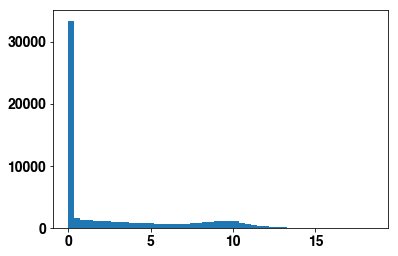

In [32]:
ga = 'GSE96682'
def tranform(x):
    if ' ' not in x: return x
    x1, x2 = x.split(' ')
    return x2 + '.' + x1[:-1] + ' ' + x1[-1]
cr = load_data('GSE96682_Processed_data.csv.gz', 6, sep=',', 
                igroup=1, group_sample_sep=' ', sample_name_transform=tranform)
hist(cr.normdata['EGFRN.GM'].mean(axis=1), 50)
ref = 'Tome-Garcia J, Tejero R, Nudelman G, Yong RL et al. Prospective Isolation and Comparison of Human Germinal Matrix and Glioblastoma EGFR<sup>+</sup> Populations with Stem Cell Properties. Stem Cell Reports 2017 May 9;8(5):1421-1429. PMID: 28434940'
res = analyze('Human', cr, ga, 'EGFRN.GM', 'EGFRP.GM', ref, transform=1, minmean=6)
res = analyze('Human', cr, ga, 'EGFRN.GM', 'EGFRN.GBM', ref, transform=1, minmean=6)
res = analyze('Human', cr, ga, 'EGFRP.GBM', 'EGFRP.GM', ref, transform=1, minmean=6)
res = analyze('Human', cr, ga, 'EGFRP.GBM', 'EGFRN.GBM', ref, transform=1, minmean=6)


In [33]:
ga = 'GSE85271'
cr = load_data('GSE85271_ExpressionAnalysis.csv.gz', 2000, sep=',', 
                igroup=1, group_sample_sep='-', sample_name_transform=lambda x: x[:2] + '-' +x[2:])
ref = 'Cui Z, Shen Y, Chen KH, Mittal SK et al. KANK1 inhibits cell growth by inducing apoptosis though regulating CXXC5 in human malignant peripheral nerve sheath tumors. Sci Rep 2017 Jan 9;7:40325. PMID: 28067315'
res = analyze('Human', cr, ga, 'WT', 'Tu', ref, transform='log2000', minmean=4000) 
# Huge file, could comsume all memories for SVA if low expression genes are allowed

Library size: 176390
groups: [('Tu', '1'), ('Tu', '2'), ('Tu', '3'), ('WT', '1'), ('WT', '2'), ('WT', '3')]
('Tu', '1') : 4534.078238783656
('Tu', '2') : 4514.150803713874
('Tu', '3') : 4457.4726522058845
('WT', '1') : 4554.969719715831
('WT', '2') : 4518.829778576767
('WT', '3') : 4279.401741762203
SVA pop of design variable: 0.426598340626
SVA pop of design variable for ridge regression: 0.442472626475
0.614; result shape: (20816, 4)
{'Ordinary power of p values': 0.67220630594991648, 'SVA power of p values': 0.38433757549102221, 'SVA GLM power of p values': 0.42659834062646068, 'SVA ridge power of p values': 0.38333478531639464, 'SVA ridge GLM power of p values': 0.44247262647488034, 'Ascertained power of p values': 0.60688963110053118}


In [34]:
ga = 'GSE97356'
geo = GEOparse.get_GEO('GSE97356')
ttl = {geo.phenotype_data['title'][i]:geo.phenotype_data['characteristics_ch1.0.ptsd'][i] 
       for i in geo.phenotype_data.index}
cr = load_data('GSE97356_RawCounts.csv.gz', 10, sep=',', 
                igroup=1, group_sample_sep=' ', sample_name_transform=lambda x:ttl[x]+' '+x)
ref = 'Kuan PF, Waszczuk MA, Kotov R, Clouston S et al. Gene expression associated with PTSD in World Trade Center responders: An RNA sequencing study. Transl Psychiatry 2017 Dec 18;7(12):1297. PMID: 29249826'
res = analyze('Human', cr, ga, 'Current', 'Past', ref, transform='log5', minmean=10)
res = analyze('Human', cr, ga, 'Current', 'Never', ref, transform='log5', minmean=10)

15-May-2019 19:13:25 INFO GEOparse - File already exist: using local version.
15-May-2019 19:13:25 INFO GEOparse - Parsing ./GSE97356_family.soft.gz: 
15-May-2019 19:13:25 DEBUG GEOparse - DATABASE: GeoMiame
15-May-2019 19:13:25 DEBUG GEOparse - SERIES: GSE97356
15-May-2019 19:13:25 DEBUG GEOparse - PLATFORM: GPL11154
15-May-2019 19:13:25 DEBUG GEOparse - SAMPLE: GSM2562148
15-May-2019 19:13:25 DEBUG GEOparse - SAMPLE: GSM2562149
15-May-2019 19:13:25 DEBUG GEOparse - SAMPLE: GSM2562150
15-May-2019 19:13:25 DEBUG GEOparse - SAMPLE: GSM2562151
15-May-2019 19:13:25 DEBUG GEOparse - SAMPLE: GSM2562152
15-May-2019 19:13:25 DEBUG GEOparse - SAMPLE: GSM2562154
15-May-2019 19:13:25 DEBUG GEOparse - SAMPLE: GSM2562155
15-May-2019 19:13:25 DEBUG GEOparse - SAMPLE: GSM2562157
15-May-2019 19:13:25 DEBUG GEOparse - SAMPLE: GSM2562159
15-May-2019 19:13:25 DEBUG GEOparse - SAMPLE: GSM2562162
15-May-2019 19:13:25 DEBUG GEOparse - SAMPLE: GSM2562164
15-May-2019 19:13:25 DEBUG GEOparse - SAMPLE: GSM2562

Library size: 25830
groups: [('Current', 'Case_10'), ('Current', 'Case_100'), ('Current', 'Case_101'), ('Current', 'Case_102'), ('Current', 'Case_105'), ('Current', 'Case_106'), ('Current', 'Case_107'), ('Current', 'Case_110'), ('Current', 'Case_112'), ('Current', 'Case_113'), ('Current', 'Case_116'), ('Current', 'Case_131'), ('Current', 'Case_133'), ('Current', 'Case_134'), ('Current', 'Case_137'), ('Current', 'Case_14'), ('Current', 'Case_140'), ('Current', 'Case_141'), ('Current', 'Case_147'), ('Current', 'Case_148'), ('Current', 'Case_149'), ('Current', 'Case_150'), ('Current', 'Case_151'), ('Current', 'Case_152'), ('Current', 'Case_153'), ('Current', 'Case_154'), ('Current', 'Case_155'), ('Current', 'Case_156'), ('Current', 'Case_157'), ('Current', 'Case_158'), ('Current', 'Case_16'), ('Current', 'Case_173'), ('Current', 'Case_175'), ('Current', 'Case_179'), ('Current', 'Case_181'), ('Current', 'Case_183'), ('Current', 'Case_185'), ('Current', 'Case_19'), ('Current', 'Case_190'), 

In [35]:
ga = 'GSE101880'
cr = load_data('GSE101880_FullRun_NormalisedData.csv.gz', 0.1, sep=',', 
                igroup=1, group_sample_sep='-', sample_name_transform=lambda x: x[0] + '.' + x[-2:] + '-' +x[1:-2])
ref = 'de Jong E, Hancock DG, Hibbert J, Wells C et al. Identification of generic and pathogen-specific cord blood monocyte transcriptomes reveals a largely conserved response in preterm and term newborn infants. J Mol Med (Berl) 2018 Feb;96(2):147-157. PMID: 29134255'
res = analyze('Human', cr, ga, 'P.EC', 'P.UN', ref, transform=1, paired=True) 
res = analyze('Human', cr, ga, 'P.SE', 'P.UN', ref, transform=1, paired=True) 
res = analyze('Human', cr, ga, 'C.EC', 'C.UN', ref, transform=1, paired=True) 
res = analyze('Human', cr, ga, 'C.SE', 'C.UN', ref, transform=1, paired=True) 
res = analyze('Human', cr, ga, 'T.SE', 'T.UN', ref, transform=1, paired=True) 
res = analyze('Human', cr, ga, 'T.EC', 'T.UN', ref, transform=1, paired=True) 

Library size: 11790
groups: [('C.EC', '11068'), ('C.EC', '11125'), ('C.EC', '11164'), ('C.EC', '11170'), ('C.EC', '11314'), ('C.SE', '11068'), ('C.SE', '11125'), ('C.SE', '11164'), ('C.SE', '11170'), ('C.SE', '11314'), ('C.UN', '11068'), ('C.UN', '11125'), ('C.UN', '11164'), ('C.UN', '11170'), ('C.UN', '11314'), ('P.EC', '11103'), ('P.EC', '11150'), ('P.EC', '11336'), ('P.EC', '21347'), ('P.EC', '31353'), ('P.SE', '11091'), ('P.SE', '11103'), ('P.SE', '11336'), ('P.SE', '21347'), ('P.SE', '31353'), ('P.UN', '11091'), ('P.UN', '11103'), ('P.UN', '11150'), ('P.UN', '11336'), ('P.UN', '21347'), ('P.UN', '31353'), ('T.EC', '11505'), ('T.EC', '11510'), ('T.EC', '11512'), ('T.EC', '11540'), ('T.SE', '11505'), ('T.SE', '11510'), ('T.SE', '11512'), ('T.SE', '11540'), ('T.UN', '11505'), ('T.UN', '11510'), ('T.UN', '11512'), ('T.UN', '11540')]
('C.EC', '11068') : 4.027957566220512
('C.EC', '11125') : 4.0401330299451645
('C.EC', '11164') : 4.0263665420304084
('C.EC', '11170') : 4.034651845664365


In [36]:
ga = 'GSE98440'
cr1 = load_data('GSE98440_norm_counts_HUVECpro_sen.csv.gz', 10, sep='\t', 
                igroup=1, group_sample_sep='_', sample_name_transform=lambda x: x[-3:] + '.' +x[:-4])
cr2 = load_data('GSE98440_norm_counts_MSCpro_sen.csv.gz', 10, sep='\t', 
                igroup=1, group_sample_sep='_', sample_name_transform=lambda x: x[-3:] + '.' +x[:-4])
cr3 = load_data('GSE98440_norm_counts_IMR90pro_sen.csv.gz', 10, sep='\t', 
                igroup=1, group_sample_sep='_', sample_name_transform=lambda x: x[-3:] + '.' +x[:-4])
ref = 'Zirkel A, Nikolic M, Sofiadis K, Mallm JP et al. HMGB2 Loss upon Senescence Entry Disrupts Genomic Organization and Induces CTCF Clustering across Cell Types. Mol Cell 2018 May 17;70(4):730-744.e6. PMID: 29706538'
res = analyze('Human', cr1, ga, 'pro.HUVEC', 'sen.HUVEC', ref, transform='log5', minmean=10, paired=True) 
res = analyze('Human', cr2, ga, 'pro.MSC', 'sen.MSC', ref, transform='log5', minmean=10, paired=True) 
res = analyze('Human', cr3, ga, 'pro.IMR90', 'sen.IMR90', ref, transform='log5', minmean=10, paired=True) 

Library size: 23995
groups: [('pro.HUVEC', 'D1'), ('pro.HUVEC', 'D2'), ('pro.HUVEC', 'D3'), ('sen.HUVEC', 'D1'), ('sen.HUVEC', 'D2'), ('sen.HUVEC', 'D3')]
('pro.HUVEC', 'D1') : 332.8116866547589
('pro.HUVEC', 'D2') : 346.6284766522072
('pro.HUVEC', 'D3') : 362.5876499106915
('sen.HUVEC', 'D1') : 341.31615207961215
('sen.HUVEC', 'D2') : 334.77290125031897
('sen.HUVEC', 'D3') : 348.95891809134986
Library size: 20376
groups: [('pro.MSC', 'A'), ('pro.MSC', 'B'), ('pro.MSC', 'C'), ('pro.MSC', 'D'), ('sen.MSC', 'A'), ('sen.MSC', 'B'), ('sen.MSC', 'C'), ('sen.MSC', 'D')]
('pro.MSC', 'A') : 478.6062762859916
('pro.MSC', 'B') : 467.43125202199934
('pro.MSC', 'C') : 465.77709479132966
('pro.MSC', 'D') : 450.23228728566806
('sen.MSC', 'A') : 424.4286638628276
('sen.MSC', 'B') : 434.8476221287609
('sen.MSC', 'C') : 440.1753477838887
('sen.MSC', 'D') : 432.87673891944354
Library size: 23337
groups: [('pro.IMR90', 'I10_fact'), ('pro.IMR90', 'I10_polyA'), ('pro.IMR90', 'I79_fact'), ('pro.IMR90', 'I79

In [37]:
ga = 'GSE115643'
geo = GEOparse.get_GEO('GSE115643')
ttl = {geo.phenotype_data['title'][i]: geo.phenotype_data['characteristics_ch1.1.transfected plasmid'][i] + '.' + geo.phenotype_data['characteristics_ch1.2.treatment'][i]
       for i in geo.phenotype_data.index}
cr = load_data('GSE115643_Full_normalised_data.csv', -Inf, sep=',', 
                igroup=1, group_sample_sep='-', sample_name_transform=lambda x: ttl[x.split('.')[0]] + '-' +x)
ref = 'Paredes R, Schneider M, Stevens A, White DJ et al. EVI1 carboxy-terminal phosphorylation is ATM-mediated and sustains transcriptional modulation and self-renewal via enhanced CtBP1 association. Nucleic Acids Res 2018 Jun 25. PMID: 29939287'
res = analyze('Human', cr, ga, 'Empty Vector.Untreated', 'Empty Vector.H2O2', ref, minmean=1e-9, transform=0.5) 
res = analyze('Human', cr, ga, 'EVI1 WT.Untreated', 'EVI1 WT.H2O2', ref, minmean=1e-9, transform=0.5) 
res = analyze('Human', cr, ga, 'EVI1 AQA.Untreated', 'EVI1 AQA.H2O2', ref, minmean=1e-9, transform=0.5) 
res = analyze('Human', cr, ga, 'EVI1 WT.H2O2', 'EVI1 AQA.H2O2', ref, minmean=1e-9, transform=0.5) 

15-May-2019 19:31:33 INFO GEOparse - File already exist: using local version.
15-May-2019 19:31:33 INFO GEOparse - Parsing ./GSE115643_family.soft.gz: 
15-May-2019 19:31:33 DEBUG GEOparse - DATABASE: GeoMiame
15-May-2019 19:31:33 DEBUG GEOparse - SERIES: GSE115643
15-May-2019 19:31:33 DEBUG GEOparse - PLATFORM: GPL18573
15-May-2019 19:31:33 DEBUG GEOparse - SAMPLE: GSM3186592
15-May-2019 19:31:33 DEBUG GEOparse - SAMPLE: GSM3186593
15-May-2019 19:31:33 DEBUG GEOparse - SAMPLE: GSM3186594
15-May-2019 19:31:33 DEBUG GEOparse - SAMPLE: GSM3186595
15-May-2019 19:31:33 DEBUG GEOparse - SAMPLE: GSM3186596
15-May-2019 19:31:33 DEBUG GEOparse - SAMPLE: GSM3186597
15-May-2019 19:31:33 DEBUG GEOparse - SAMPLE: GSM3186598
15-May-2019 19:31:33 DEBUG GEOparse - SAMPLE: GSM3186599
15-May-2019 19:31:33 DEBUG GEOparse - SAMPLE: GSM3186600
15-May-2019 19:31:33 DEBUG GEOparse - SAMPLE: GSM3186601
15-May-2019 19:31:33 DEBUG GEOparse - SAMPLE: GSM3186602
15-May-2019 19:31:33 DEBUG GEOparse - SAMPLE: GSM31

Library size: 11579
groups: [('EVI1 AQA.H2O2', 'SM2_24_A8H_2_S33.sorted.bam'), ('EVI1 AQA.H2O2', 'SM2_40_A8H_3_S15.sorted.bam'), ('EVI1 AQA.H2O2', 'SM2_8_A8H_1_S2.sorted.bam'), ('EVI1 AQA.Untreated', 'SM2_20_A8_2_S37.sorted.bam'), ('EVI1 AQA.Untreated', 'SM2_36_A8_3_S20.sorted.bam'), ('EVI1 AQA.Untreated', 'SM2_4_A8_1_S6.sorted.bam'), ('EVI1 WT.H2O2', 'SM2_23_W8H_2_S34.sorted.bam'), ('EVI1 WT.H2O2', 'SM2_39_W8H_3_S17.sorted.bam'), ('EVI1 WT.H2O2', 'SM2_7_W8H_1_S3.sorted.bam'), ('EVI1 WT.Untreated', 'SM2_19_W8_2_S39.sorted.bam'), ('EVI1 WT.Untreated', 'SM2_35_W8_3_S21.sorted.bam'), ('EVI1 WT.Untreated', 'SM2_3_W8_1_S16.sorted.bam'), ('Empty Vector.H2O2', 'SM2_22_E8H_2_S35.sorted.bam'), ('Empty Vector.H2O2', 'SM2_38_E8H_3_S18.sorted.bam'), ('Empty Vector.H2O2', 'SM2_6_E8H_1_S4.sorted.bam'), ('Empty Vector.Untreated', 'SM2_18_E8_2_S40.sorted.bam'), ('Empty Vector.Untreated', 'SM2_2_E8_1_S27.sorted.bam'), ('Empty Vector.Untreated', 'SM2_34_E8_3_S22.sorted.bam'), ('Untransfected.H2O2', 'SM2

In [38]:
ga = 'GSE95477'
cr = load_data('GSE95477_Total_Gene_Reads_-_All_Genes.csv.gz', 10, sep=',', 
                igroup=2, group_sample_sep=' ')
ref = 'Reyes JM, Silva E, Chitwood JL, Schoolcraft WB et al. Differing molecular response of young and advanced maternal age human oocytes to IVM. Hum Reprod 2017 Nov 1;32(11):2199-2208. PMID: 29025019'
res = analyze('Human', cr, ga, 'AMA GV', 'YNG GV', ref, transform='log5', minmean=10)
res = analyze('Human', cr, ga, 'AMA GV', 'AMA MII', ref, transform='log5', minmean=10, paired=True)
res = analyze('Human', cr, ga, 'YNG MII', 'YNG GV', ref, transform='log5', minmean=10, paired=True)
res = analyze('Human', cr, ga, 'AMA MII', 'YNG MII', ref, transform='log5', minmean=10)

Only the first of the duplicated indices will be kept:
                  AMA GV                                                      \
               - 1.rpkm     - 2.rpkm     - 3.rpkm     - 4.rpkm     - 5.rpkm   
Feature ID                                                                    
1-Mar       2279.285515  2614.088137  2132.091393  3087.421033  2945.739303   
2-Mar         16.914920    35.159772    40.410467    19.236268    24.026206   

                AMA MII                                                      \
               - 1.rpkm     - 2.rpkm     - 3.rpkm     - 4.rpkm     - 5.rpkm   
Feature ID                                                                    
1-Mar       3201.475394  4598.721557  3553.602469  2554.028992  3736.074636   
2-Mar          2.821926     0.000000     4.864617     2.050605    12.067425   

                 YNG GV                                                      \
               - 1.rpkm     - 2.rpkm     - 3.rpkm     - 4.rpkm     - 5.rp

In [39]:
ga = 'GSE95243'
cr = load_data('GSE95243_Sareen-HT-2017_data_for_GEO_-_Raw_read_counts.csv', 10, sep=',', 
                igroup=1, group_sample_sep='_', 
               sample_name_transform=lambda x:x[-3:]+'.'+x[4:] if 'aHT' not in x else x[4:])
ref = 'Rajamani U, Gross AR, Hjelm BE, Sequeira A et al. Super-Obese Patient-Derived iPSC Hypothalamic Neurons Exhibit Obesogenic Signatures and Hormone Responses. Cell Stem Cell 2018 May 3;22(5):698-712.e9. PMID: 29681516'
res = analyze('Human', cr, ga, 'CTR.iHT', 'OBS.iHT', ref, transform='log5', minmean=10)
res = analyze('Human', cr, ga, 'CTR.iHT', 'aHT', ref, transform='log5', minmean=10)
res = analyze('Human', cr, ga, 'aHT', 'OBS.iHT', ref, transform='log5', minmean=10)

Library size: 30315
groups: [('CTR.iHT', '02iCTR'), ('CTR.iHT', '03iCTR'), ('CTR.iHT', '201iCTR'), ('CTR.iHT', '25iCTR'), ('CTR.iHT', '688iCTR'), ('CTR.iHT', '80iCTR'), ('CTR.iHT', '87iCTR'), ('CTR.iMN', '201iCTR'), ('CTR.iMN', '87iCTR'), ('OBS.iHT', '02iOBS'), ('OBS.iHT', '03iOBS'), ('OBS.iHT', '74iOBS'), ('OBS.iHT', '77iOBS'), ('OBS.iHT', '90iOBS'), ('aHT', '1662'), ('aHT', '1838'), ('aHT', '1843'), ('aHT', '2266'), ('aHT', '2884')]
('CTR.iHT', '02iCTR') : 723.6558645374454
('CTR.iHT', '03iCTR') : 378.7103056167401
('CTR.iHT', '201iCTR') : 475.1723843612322
('CTR.iHT', '25iCTR') : 395.52365914096964
('CTR.iHT', '688iCTR') : 423.47436949339243
('CTR.iHT', '80iCTR') : 612.3939069383254
('CTR.iHT', '87iCTR') : 371.7121393171808
('CTR.iMN', '201iCTR') : 466.6539207048461
('CTR.iMN', '87iCTR') : 569.0281718061669
('OBS.iHT', '02iOBS') : 586.3567951541851
('OBS.iHT', '03iOBS') : 637.0260820484588
('OBS.iHT', '74iOBS') : 548.4351459251105
('OBS.iHT', '77iOBS') : 298.0675660792949
('OBS.iHT'

In [40]:
ga = 'GSE105436'
cr1 = load_data('GSE105436_processed_data.csv', 0.1, sep=',', igroup=1, group_sample_sep='_')
cr2 = load_data('GSE105436_processed_data_exp2.csv', 0.1, sep=',', igroup=1, group_sample_sep='-')
ref = 'Baird TD, Cheng KC, Chen YC, Buehler E et al. ICE1 promotes the link between splicing and nonsense-mediated mRNA decay. Elife 2018 Mar 12;7. PMID: 29528287'
res = analyze('Human', cr1, ga, 'siNS', 'siICE1', ref, transform='log0.05', minmean=0.10)
res = analyze('Human', cr1, ga, 'siNS', 'siUPF1', ref, transform='log0.05', minmean=0.10)
res = analyze('Human', cr1, ga, 'siICE1', 'siUPF1', ref, transform='log0.05', minmean=0.10)
res = analyze('Human', cr2, ga, 'NT', 'UPF3b', ref, transform='log0.05', minmean=0.10)
res = analyze('Human', cr2, ga, 'NT', 'ICE1', ref, transform='log0.05', minmean=0.10)
res = analyze('Human', cr2, ga, 'UPF3b', 'ICE1', ref, transform='log0.05', minmean=0.10)

Only the first of the duplicated indices will be kept:
                     siICE1                                siNS             \
                     1_TPM      2_TPM         3_TPM      1_TPM      2_TPM   
Ensembl                                                                     
ENSG00000227232   0.000000   0.000000  0.000000e+00   0.000000   0.260402   
ENSG00000237491   1.476321   1.061315  8.365173e-01   0.616726   0.641915   
ENSG00000228794   0.908208   0.592636  6.095904e-01   0.863088   0.709150   
ENSG00000228794   0.955784   0.415657  3.629530e-01   0.302559   0.801929   
ENSG00000187634   1.072725   0.417879  7.775150e-01   0.116825   0.434829   
ENSG00000188290   8.236530   7.950759  7.539259e+00   7.883798   7.268087   
ENSG00000188290   4.015226   2.785201  3.070676e+00   2.951008   4.350144   
ENSG00000188290   0.353678   0.179132  1.945477e-01   0.155319   0.403964   
ENSG00000188157   0.968080   0.491197  4.990405e-01   0.615218   0.756531   
ENSG00000131591   0.

In [41]:
ga = 'GSE111195'
cr = load_data('GSE111195_raw_counts.csv', 10, sep=',', igroup=1, group_sample_sep='.',
              sample_name_transform=lambda x:x.split('_',1)[1]+'.'+x)
ref = 'Mélissa Mariani, Pouria Dasmeh, Audray Fortin, Mario Kalamujic, Elise Caron, Alexander N Harrison, Sandra Cervantes-Ortiz, Espérance Mukawera, Adrian Serohijos, Nathalie Grandvaux. RNASeq analysis identifies non-canonical role of STAT2 and IRF9 in the regulation of a STAT1-independent antiviral and immunoregulatory transcriptional program induced by IFNβ and TNFα. bioRxiv 273623. doi:10.1101/273623.'
res = analyze('Human', cr, ga, 'siIRF9-NS', 'siCtrl_NS', ref, transform='log5', minmean=10)
res = analyze('Human', cr, ga, 'siSTAT2-NS', 'siCtrl_NS', ref, transform='log5', minmean=10)
res = analyze('Human', cr, ga, 'siCtrl-IFN-TNF', 'siIRF9-IFN-TNF', ref, transform='log5', minmean=10)
res = analyze('Human', cr, ga, 'siCtrl-IFN-TNF', 'siSTAT2-IFN-TNF', ref, transform='log5', minmean=10)
res = analyze('Human', cr, ga, 'siIRF9-NS', 'siIRF9-IFN-TNF', ref, transform='log5', minmean=10)
res = analyze('Human', cr, ga, 'siSTAT2-NS', 'siSTAT2-IFN-TNF', ref, transform='log5', minmean=10)

Library size: 63677
groups: [('siCtrl-IFN-TNF', 'NG-14_siCtrl-IFN-TNF'), ('siCtrl-IFN-TNF', 'NG-2_siCtrl-IFN-TNF'), ('siCtrl-IFN-TNF', 'NG-8_siCtrl-IFN-TNF'), ('siCtrl_NS', 'NG-13_siCtrl_NS'), ('siCtrl_NS', 'NG-1_siCtrl_NS'), ('siCtrl_NS', 'NG-7_siCtrl_NS'), ('siIRF9-IFN-TNF', 'NG-12_siIRF9-IFN-TNF'), ('siIRF9-IFN-TNF', 'NG-18_siIRF9-IFN-TNF'), ('siIRF9-IFN-TNF', 'NG-6_siIRF9-IFN-TNF'), ('siIRF9-NS', 'NG-11_siIRF9-NS'), ('siIRF9-NS', 'NG-17_siIRF9-NS'), ('siIRF9-NS', 'NG-5_siIRF9-NS'), ('siSTAT2-IFN-TNF', 'NG-10_siSTAT2-IFN-TNF'), ('siSTAT2-IFN-TNF', 'NG-16_siSTAT2-IFN-TNF'), ('siSTAT2-IFN-TNF', 'NG-4_siSTAT2-IFN-TNF'), ('siSTAT2-NS', 'NG-15_siSTAT2-NS'), ('siSTAT2-NS', 'NG-3_siSTAT2-NS'), ('siSTAT2-NS', 'NG-9_siSTAT2-NS')]
('siCtrl-IFN-TNF', 'NG-14_siCtrl-IFN-TNF') : 675.0645355850422
('siCtrl-IFN-TNF', 'NG-2_siCtrl-IFN-TNF') : 538.5536791314837
('siCtrl-IFN-TNF', 'NG-8_siCtrl-IFN-TNF') : 741.8063932448733
('siCtrl_NS', 'NG-13_siCtrl_NS') : 790.9601930036188
('siCtrl_NS', 'NG-1_siCtrl

In [42]:
ga = 'GSE109177'
cr1 = load_data('GSE109177_Ctrl_Untr_vs_Ctrl_PR20-ExpDiff_k562_.csv', 5, sep=',', igroup=1, group_sample_sep='-')
cr2 = load_data('GSE109177_SafePR50_vs_TMX2PR50-ExpDiff_neurons_.csv', 5, sep=',', igroup=1, group_sample_sep='_')
ref = 'Kramer NJ, Haney MS, Morgens DW, Jovičić A et al. CRISPR-Cas9 screens in human cells and primary neurons identify modifiers of C9ORF72 dipeptide-repeat-protein toxicity. Nat Genet 2018 Apr;50(4):603-612. PMID: 29507424'
res = analyze('Human', cr1, ga, 'Ctrl_Untr', 'Ctrl_PR20', ref, transform='log2.5', minmean=5)
res = analyze('Human', cr2, ga, 'Safe', 'TMX2', ref, transform='log2.5', minmean=5)

Library size: 26475
groups: [('Ctrl_PR20', '1'), ('Ctrl_PR20', '2'), ('Ctrl_PR20', '3'), ('Ctrl_Untr', '1'), ('Ctrl_Untr', '2'), ('Ctrl_Untr', '3')]
('Ctrl_PR20', '1') : 335.72492548963424
('Ctrl_PR20', '2') : 326.7882379060495
('Ctrl_PR20', '3') : 329.7681591355061
('Ctrl_Untr', '1') : 333.6734731836242
('Ctrl_Untr', '2') : 348.68380497657415
('Ctrl_Untr', '3') : 335.82163524793236
Library size: 24411
groups: [('Safe', 'PR50-1_S7'), ('Safe', 'PR50-2_S8'), ('Safe', 'PR50-3_S9'), ('TMX2', 'PR50-1_S10'), ('TMX2', 'PR50-2_S11'), ('TMX2', 'PR50-3_S12')]
('Safe', 'PR50-1_S7') : 660.1479586987369
('Safe', 'PR50-2_S8') : 660.9536019748446
('Safe', 'PR50-3_S9') : 664.337090731501
('TMX2', 'PR50-1_S10') : 667.0250131105281
('TMX2', 'PR50-2_S11') : 664.0778743334786
('TMX2', 'PR50-3_S12') : 668.0017777642269
SVA pop of design variable: 0.179112108817
SVA pop of design variable for ridge regression: 0.197924384118
0.249; result shape: (12328, 4)
{'Ordinary power of p values': 0.30096817100576517,

In [43]:
ga = 'GSE69810'
cr = load_data('GSE69810_DLBCL_expressionMatrix_mm1mature.csv.gz', 10, sep='\t', igroup=1, group_sample_sep='_',
              sample_name_transform=lambda x:x[::-1])
ref = 'Leivonen SK, Icay K, Jäntti K, Siren I et al. MicroRNAs regulate key cell survival pathways and mediate chemosensitivity during progression of diffuse large B-cell lymphoma. Blood Cancer J 2017 Dec 15;7(12):654. PMID: 29242506'
res = analyze('Human', cr, ga, 'D', 'R', ref, transform='log5', minmean=10, paired=True)

Library size: 492
groups: [('D', '1LCBLD'), ('D', '2LCBLD'), ('D', '3LCBLD'), ('D', '4LCBLD'), ('D', '5LCBLD'), ('D', '6LCBLD'), ('D', '7LCBLD'), ('R', '2LCBLD'), ('R', '3LCBLD'), ('R', '4LCBLD'), ('R', '5LCBLD'), ('R', '6LCBLD'), ('R', '7LCBLD')]
('D', '1LCBLD') : 152.52272727272728
('D', '2LCBLD') : 128.3409090909091
('D', '3LCBLD') : 161.5909090909091
('D', '4LCBLD') : 63.625
('D', '5LCBLD') : 91.20454545454545
('D', '6LCBLD') : 273.21590909090907
('D', '7LCBLD') : 265.89772727272725
('R', '2LCBLD') : 106.02272727272727
('R', '3LCBLD') : 140.17045454545453
('R', '4LCBLD') : 150.13636363636363
('R', '5LCBLD') : 69.9090909090909
('R', '6LCBLD') : 207.5909090909091
('R', '7LCBLD') : 151.63636363636363
Some sample names are not paired and removed:
valid names: [(0, '2LCBLD'), (0, '3LCBLD'), (0, '4LCBLD'), (0, '5LCBLD'), (0, '6LCBLD'), (0, '7LCBLD'), (1, '2LCBLD'), (1, '3LCBLD'), (1, '4LCBLD'), (1, '5LCBLD'), (1, '6LCBLD'), (1, '7LCBLD')]
all   names: [(0, '1LCBLD'), (0, '2LCBLD'), (0, '

In [44]:
ga = 'GSE99897'
geo = GEOparse.get_GEO('GSE99897')
ttl = {geo.phenotype_data['title'][i].split('_')[-1]: geo.phenotype_data['characteristics_ch1.1.event distant metastasis'][i]
       for i in geo.phenotype_data.index}
cr = load_data('GSE99897_expected_counts_RC_data.csv.gz', 1, sep=',', igroup=1, group_sample_sep='_',
              sample_name_transform=lambda x:'metastasis'+str(ttl[x])+'_'+x)
ref = 'Wolff A, Bayerlová M, Gaedcke J, Kube D et al. A comparative study of RNA-Seq and microarray data analysis on the two examples of rectal-cancer patients and Burkitt Lymphoma cells. PLoS One 2018;13(5):e0197162. PMID: 29768462'
res = analyze('Human', cr, ga, 'metastasis0', 'metastasis1', ref, transform='log0.2', minmean=0.5)

15-May-2019 20:15:44 INFO GEOparse - File already exist: using local version.
15-May-2019 20:15:44 INFO GEOparse - Parsing ./GSE99897_family.soft.gz: 
15-May-2019 20:15:44 DEBUG GEOparse - DATABASE: GeoMiame
15-May-2019 20:15:44 DEBUG GEOparse - SERIES: GSE99897
15-May-2019 20:15:44 DEBUG GEOparse - PLATFORM: GPL11154
15-May-2019 20:15:44 DEBUG GEOparse - SAMPLE: GSM2663914
15-May-2019 20:15:44 DEBUG GEOparse - SAMPLE: GSM2663915
15-May-2019 20:15:44 DEBUG GEOparse - SAMPLE: GSM2663916
15-May-2019 20:15:44 DEBUG GEOparse - SAMPLE: GSM2663917
15-May-2019 20:15:44 DEBUG GEOparse - SAMPLE: GSM2663918
15-May-2019 20:15:44 DEBUG GEOparse - SAMPLE: GSM2663919
15-May-2019 20:15:44 DEBUG GEOparse - SAMPLE: GSM2663920
15-May-2019 20:15:44 DEBUG GEOparse - SAMPLE: GSM2663921
15-May-2019 20:15:44 DEBUG GEOparse - SAMPLE: GSM2663922
15-May-2019 20:15:44 DEBUG GEOparse - SAMPLE: GSM2663923


Library size: 58812
groups: [('metastasis0', 'P0112'), ('metastasis0', 'P0160'), ('metastasis0', 'P0294'), ('metastasis0', 'P0300'), ('metastasis1', 'P0022'), ('metastasis1', 'P0028'), ('metastasis1', 'P0048'), ('metastasis1', 'P0123'), ('metastasis1', 'P0291'), ('metastasis1', 'P0311')]
('metastasis0', 'P0112') : 5.180715795034339
('metastasis0', 'P0160') : 7.285760697305876
('metastasis0', 'P0294') : 6.039149498151084
('metastasis0', 'P0300') : 7.042340200739546
('metastasis1', 'P0022') : 5.437160591653464
('metastasis1', 'P0028') : 5.722757527733763
('metastasis1', 'P0048') : 6.463523507659835
('metastasis1', 'P0123') : 7.986574220813545
('metastasis1', 'P0291') : 5.6761621764395045
('metastasis1', 'P0311') : 5.570158478605395
SVA pop of design variable: 0.846222006592
SVA pop of design variable for ridge regression: 0.910079543956
0.888; result shape: (21657, 4)
{'Ordinary power of p values': 0.89038271484591336, 'SVA power of p values': 0.80678185245513589, 'SVA GLM power of p val

In [45]:
ga = 'GSE109542'
geo = GEOparse.get_GEO('GSE109542')
ttl = {geo.phenotype_data['title'][i].split('[')[-1][:-1]: geo.phenotype_data['title'][i]
       for i in geo.phenotype_data.index}
cr = load_data('GSE109542_STAR.csv.gz', 10, sep=',', igroup=1, group_sample_sep='_',
              sample_name_transform=lambda x:ttl[x].replace('-', '_'))
ref = ' Ferrari de Andrade L, Tay RE, Pan D, Luoma AM et al. Antibody-mediated inhibition of MICA and MICB shedding promotes NK cell-driven tumor immunity. Science 2018 Mar 30;359(6383):1537-1542. PMID: 29599246'
res = analyze('Human', cr, ga, 'Isotype', '7C6', ref, transform='log5', minmean=10)

15-May-2019 20:18:26 INFO GEOparse - File already exist: using local version.
15-May-2019 20:18:26 INFO GEOparse - Parsing ./GSE109542_family.soft.gz: 
15-May-2019 20:18:26 DEBUG GEOparse - DATABASE: GeoMiame
15-May-2019 20:18:26 DEBUG GEOparse - SERIES: GSE109542
15-May-2019 20:18:26 DEBUG GEOparse - PLATFORM: GPL17021
15-May-2019 20:18:26 DEBUG GEOparse - PLATFORM: GPL18573
15-May-2019 20:18:26 DEBUG GEOparse - SAMPLE: GSM2946061
15-May-2019 20:18:26 DEBUG GEOparse - SAMPLE: GSM2946062
15-May-2019 20:18:26 DEBUG GEOparse - SAMPLE: GSM2946063
15-May-2019 20:18:26 DEBUG GEOparse - SAMPLE: GSM2946064
15-May-2019 20:18:26 DEBUG GEOparse - SAMPLE: GSM2946065
15-May-2019 20:18:26 DEBUG GEOparse - SAMPLE: GSM2946066
15-May-2019 20:18:26 DEBUG GEOparse - SAMPLE: GSM2977598
15-May-2019 20:18:26 DEBUG GEOparse - SAMPLE: GSM2977599
15-May-2019 20:18:26 DEBUG GEOparse - SAMPLE: GSM2977600


Only the first of the duplicated indices will be kept:
                   7C6                                   Isotype                \
        rep1 [LFDA_7] rep2 [LFDA_8] rep3 [LFDA_9] rep1 [LFDA_4] rep2 [LFDA_5]   
Gene_ID                                                                         
1-Mar        0.000000      0.000000      0.000000      0.944646      0.000000   
2-Mar      467.315604    505.064773    435.027346    472.323109    435.892151   

                       
        rep3 [LFDA_6]  
Gene_ID                
1-Mar        0.000000  
2-Mar      484.305538  
Library size: 25435
groups: [('7C6', 'rep1 [LFDA_7]'), ('7C6', 'rep2 [LFDA_8]'), ('7C6', 'rep3 [LFDA_9]'), ('Isotype', 'rep1 [LFDA_4]'), ('Isotype', 'rep2 [LFDA_5]'), ('Isotype', 'rep3 [LFDA_6]')]
('7C6', 'rep1 [LFDA_7]') : 644.2895533686601
('7C6', 'rep2 [LFDA_8]') : 525.4519303557911
('7C6', 'rep3 [LFDA_9]') : 637.9174867524603
('Isotype', 'rep1 [LFDA_4]') : 713.0412566237699
('Isotype', 'rep2 [LFDA_5]') : 798.90

In [46]:
ga = 'GSE85606'
cr = load_data('GSE85606_RNAseq_processed.csv.gz', 10, sep=',', igroup=1, group_sample_sep='_',
              sample_name_transform=lambda x:x[:-1]+'_'+x[-1])
ref = 'Pidsley R, Lawrence MG, Zotenko E, Niranjan B et al. Enduring epigenetic landmarks define the cancer microenvironment. Genome Res 2018 May;28(5):625-638. PMID: 29650553'
res = analyze('Human', cr, ga, 'CAF', 'NPF', ref, transform='log5', minmean=10, paired=True)

Library size: 57819
groups: [('CAF', '1'), ('CAF', '2'), ('CAF', '3'), ('CAF', '5'), ('NPF', '1'), ('NPF', '2'), ('NPF', '3'), ('NPF', '5')]
('CAF', '1') : 244.61672025723473
('CAF', '2') : 270.0610932475884
('CAF', '3') : 437.99003215434084
('CAF', '5') : 301.4790996784566
('NPF', '1') : 289.0684887459807
('NPF', '2') : 259.308038585209
('NPF', '3') : 686.7038585209003
('NPF', '5') : 343.71254019292604
SVA pop of design variable: 1.05213281159
SVA pop of design variable for ridge regression: 1.11904895138
1.042; result shape: (14683, 4)
{'Ordinary power of p values': 1.0343072038178731, 'SVA power of p values': 1.0794561280092163, 'SVA GLM power of p values': 1.0521328115918445, 'SVA ridge power of p values': 1.0788115998172862, 'SVA ridge GLM power of p values': 1.1190489513795194, 'Ascertained power of p values': 1.1067305388977575}


In [47]:
ga = 'GSE103327'
cr = load_data('GSE103327_RPKM.csv.gz', 0.1, sep=',', igroup=1, group_sample_sep='_',
              sample_name_transform=lambda x:x)
ref = ' Kempinska K, Malik B, Borkin D, Klossowski S et al. Pharmacologic Inhibition of the Menin-MLL Interaction Leads to Transcriptional Repression of <i>PEG10</i> and Blocks Hepatocellular Carcinoma. Mol Cancer Ther 2018 Jan;17(1):26-38. PMID: 29142068'
res = analyze('Human', cr, ga, 'MI503', 'DMSO', ref, transform='log0.05', minmean=0.10)

Only the first of the duplicated indices will be kept:
            DMSO                         MI503                    
              1         2         3         1         2         3
Gene                                                             
1-Mar  1.018387  1.033923  1.017354  0.378296  0.880721  1.005214
2-Mar  7.465296  6.136830  6.997077  8.959847  6.253454  7.091998
Library size: 25268
groups: [('DMSO', '1'), ('DMSO', '2'), ('DMSO', '3'), ('MI503', '1'), ('MI503', '2'), ('MI503', '3')]
('DMSO', '1') : 7.684173867293977
('DMSO', '2') : 7.5116978335496265
('DMSO', '3') : 7.514651502271241
('MI503', '1') : 7.471447728617771
('MI503', '2') : 7.660767272550297
('MI503', '3') : 7.676198157040884
SVA pop of design variable: 0.329446896718
SVA pop of design variable for ridge regression: 0.371581708575
0.47; result shape: (14821, 4)
{'Ordinary power of p values': 0.52017718080003916, 'SVA power of p values': 0.31599440937841999, 'SVA GLM power of p values': 0.32944689671803734

In [48]:
len(results['Mouse']) + len(results['Human'])

103

In [49]:
# pd.DataFrame(results['Human']).T.apply(pd.to_numeric, errors='ignore')

## Figure 3

Mouse total studies: 23
Human total studies: 20


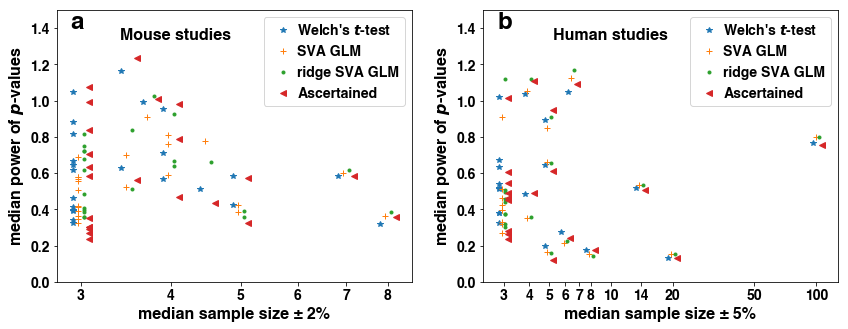

In [50]:
figure(figsize=(14, 5))
for i, sp in enumerate(['Mouse', 'Human']):
    ax = subplot(121+i)
    pops = pd.DataFrame(results[sp]).T.apply(pd.to_numeric, errors='ignore').groupby(level=0).median()
    print(sp, 'total studies:', pops.shape[0])
    dx = 0.01 * (i + 1)
    plot((pops['Mean of n number'])*(1-2.5*dx), pops["Ordinary power of p values"], '*')
    plot((pops['Mean of n number'])*(1-  dx), pops["SVA GLM power of p values"], '+')
    plot((pops['Mean of n number'])*(1+  dx), pops["SVA ridge GLM power of p values"], '.')
    plot((pops['Mean of n number'])*(1+2.5*dx), pops["Ascertained power of p values"], '<')
#     plot(log2(pops['Mean of n number'])+2*dx, pops["Asc. SVA ridge power of p values"], '<')
    xlabel('median sample size ± '+str(int(2.5*dx*100))+'%', fontweight='bold', fontsize=16)
    ax.set_xscale('log', basex=2)
    ax.set_xticks([3, 4, 5, 6, 7, 8]+ [10, 14, 20, 50, 100]*i)
    ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    ylabel('median power of $p$-values',   fontweight='bold', fontsize=16)
    legend(["Welch's $t$-test", 'SVA GLM', 'ridge SVA GLM', 'Ascertained', 'Asc. SVA ridge'], handletextpad=0)
    ylim(0.0, 1.5)
    text(2.9-i*0.1, 1.4, 'ab'[i], fontsize=24)
    text([3.4, 5.2][i], 1.34, sp + ' studies', fontsize=16)

In [51]:
pd.DataFrame(results['Mouse']).T.apply(pd.to_numeric, errors='ignore').groupby(level=0).median().median()

# of analyzed genes                14472.500000
Ascertained LFDR < 0.3                20.000000
Ascertained power of p values          0.571561
Mean of n number                       3.000000
Ordinary LFDR < 0.3                    0.000000
Ordinary power of p values             0.585452
SVA GLM power of p values              0.555110
SVA LFDR < 0.3                         0.000000
SVA power of p values                  0.494748
SVA ridge GLM power of p values        0.618972
SVA ridge LFDR < 0.3                   0.000000
SVA ridge power of p values            0.572246
dtype: float64

In [52]:
pd.DataFrame(results['Human']).T.apply(pd.to_numeric, errors='ignore').groupby(level=0).median().median()

# of analyzed genes                14260.750000
Ascertained LFDR < 0.3                 1.750000
Ascertained power of p values          0.490513
Mean of n number                       4.000000
Ordinary LFDR < 0.3                    0.000000
Ordinary power of p values             0.519342
SVA GLM power of p values              0.412568
SVA LFDR < 0.3                         0.000000
SVA power of p values                  0.382014
SVA ridge GLM power of p values        0.448580
SVA ridge LFDR < 0.3                   0.000000
SVA ridge power of p values            0.387176
dtype: float64

In [53]:
pd.DataFrame(results['Mouse']).T

# of analyzed genes  \
GSE101537         WT(6) ~ CBP(3)                                    14416   
                  WT(6) ~ Triallelic(3)                             14489   
                  WT(6) ~ p300(3)                                   14528   
GSE102220         WT(3) ~ Tax delta_PBM(3)                           9850   
GSE102857         E10V(3) ~ E10D(3)                                 20516   
                  E10V(3) ~ E9V(3)                                  20623   
                  E9D(3) ~ E10D(3)                                  20382   
                  E9D(3) ~ E9V(3)                                   20555   
GSE102858         Rgr(6) ~ Flat(4)                                  15808   
GSE104415         Tert_pos(3) ~ Tert_neg(3)                         12777   
GSE104530         oldBPH2J(3) ~ oldBPN3J(3)                         14347   
                  youngBPH2J(3) ~ oldBPH2J(3)                       14268   
                  youngBPH2J(3) ~ oldBPN3J(3)                       14235   
GSE105768         Ctr(8) ~ Hoxb5(8)                                 14843   
GSE106692         STINGgt_GCV(4) ~ STINGgt_PBS(3)                   11590   
                  STINGgt_GCV(4) ~ WT_GCV(4)                        11600   
                  WT_PBS(4) ~ STINGgt_PBS(3)                        11631   
                  WT_PBS(4) ~ WT_GCV(4)                             11604   
GSE109171         Control(14) ~ Recovery(7)                         12188   
                  EarlyDisease(7) ~ LateDisease(7)                  12181   
                  Recovery(7) ~ LateDisease(7)                      12275   
GSE109177         Ctrl_Untr(3) ~ Ctrl_PR20(3)                       13914   
                  Safe_PR50(3) ~ TMX2_PR50(3)                       16450   
GSE110243         WT_L60(3) ~ KO_L60(3)                              9609   
                  WT_LD60(3) ~ KO_LD60(3)                            9611   
GSE75185          dblKoFlt3ITD(4) ~ dblKo(4)                        11804   
                  wt(4) ~ dblKo(4)                                  11643   
                  wt(4) ~ dblKoFlt3ITD(4)                           11644   
GSE75187          WT(3) ~ DKOITD(4)                                 10632   
GSE81125          CV(4) ~ GF(4)                                     17332   
GSE81803          dmso_ko(3) ~ dmso_wt(3)                           15075   
                  dmso_ko(3) ~ jq1_ko(3)                            14449   
                  dmso_wt(3) ~ jq1_wt(3)                            14496   
                  jq1_ko(3) ~ jq1_wt(3)                             14441   
GSE87602          Sea_level(3) ~ Hypoxia_D4(3)                      18300   
GSE89272          N_young(4) ~ N_old(4)                             17540   
                  df_old(4) ~ N_old(4)                              17679   
                  df_young(4) ~ N_young(4)                          17535   
                  df_young(4) ~ df_old(4)                           17760   
GSE91078          Gas2l3KO(3) ~ CTR(3)                              14643   
GSE94264,GSE94263 c2(3) ~ c3(3)                                     14479   
                  wt(4) ~ ko(4)                                     13382   
GSE95682          daily(5) ~ vehicle(5)                             14261   
                  daily(5) ~ weekly(5)                              14266   
                  vehicle(5) ~ weekly(5)                            14261   
GSE97440          MOLM13-0-hrs(3) ~ MOLM13-12-hrs(3)                12620   
                  MOLM13-12-hrs(3) ~ MOLM13-72-hrs(3)               12654   
GSE97976          HOM(3) ~ HET(3)                                   14745   
GSE99397          Control(3) ~ CreNeg(3)                            22576   
                  Control(3) ~ CrePos(3)                            22561   

                                                      Ascertained LFDR < 0.3  \
GSE101537         WT(6) ~ CBP(3)              

In [55]:
writer = pd.ExcelWriter('../Paper/ROSELY/Supplementary Table 1.xlsx', engine='xlsxwriter')
pd.DataFrame(
{'Description':{
    'General':'This file contains analysis results of all published RNA-seq data published between 1.Jan.2017 and 1.Jun.2018.',
    'URL': 'https://www.ncbi.nlm.nih.gov/gds',
'Mouse':"""
Search: csv[All Fields] AND sequencing[All Fields] AND "Mus musculus"[porgn] AND ("2017/01/01"[PDAT] : "2018/06/30"[PDAT])
Search Date: 30-Aug-18""",
'Human':
"""Search: csv[All Fields] AND sequencing[All Fields] AND "Homo sapiens"[porgn] AND ("2017/01/01"[PDAT] : "2018/06/30"[PDAT])
Search Date: 4-Sep-18""",
'Inclusion criteria':
"""1. Count matrix in CSV format provided
2. Paper published.
3. Each group with at least 3 replicates."""}}).to_excel(writer, sheet_name='Description')
pd.DataFrame(results['Mouse']).T.to_excel(writer, sheet_name='Mouse')
pd.DataFrame(results['Human']).T.to_excel(writer, sheet_name='Human')
writer.save()